# make_grid:
## Make high res grid, choose either GEBCO_v2023 or bedmachine v3
### Version id:
### bedmachine v3
### editing the RUNNING v5 version, tweaking any new dodgy spots.

In [68]:

run ='amery'
vers='v2km'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask

# Set model vertical coordinate settings

N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline


In [69]:
mr = 2
grid_xLims= (1500,3300) #km
grid_yLims= (0,1500) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

In [70]:
#load GEBCO 2023 geometry

gebco_2023_bed = os.path.join(data_dir,'raw','GEBCO_2023','GEBCO_2023_sub_ice_topo.nc')

g23 = xr.load_dataset(gebco_2023_bed)

g23 = g23.sel(lon=slice(30,110),lat=slice(-85,-55))
g23

long,latg = np.meshgrid(g23.lon,g23.lat)
g23 = g23.assign_coords({"longitude": (("lat", "lon"), long), "latitude": (("lat", "lon"), latg)})

In [71]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(1e6,3.3e6)).sel(y=slice(1.5e6,0)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive


In [72]:
whichBathy='bedmachine' #options: 'bedmachine' or 'gebco'
if whichBathy =='gebco':
    # make new dataset with all variables on same grid
    geom = bm3.draft.to_dataset(name='draft')

    # interp GEBCO2023 bathy to this grid.
    g23_bathy_i = -griddata((g23['longitude'].values.flatten(),g23['latitude'].values.flatten()),g23['elevation'].values.flatten(),(geom.lon.values,geom.lat.values),'nearest').astype(np.float32)
    geom['bathy']=(['y','x'],g23_bathy_i)


    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
elif whichBathy =='bedmachine':
    
    geom = bm3
    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
    


<Figure size 640x480 with 0 Axes>

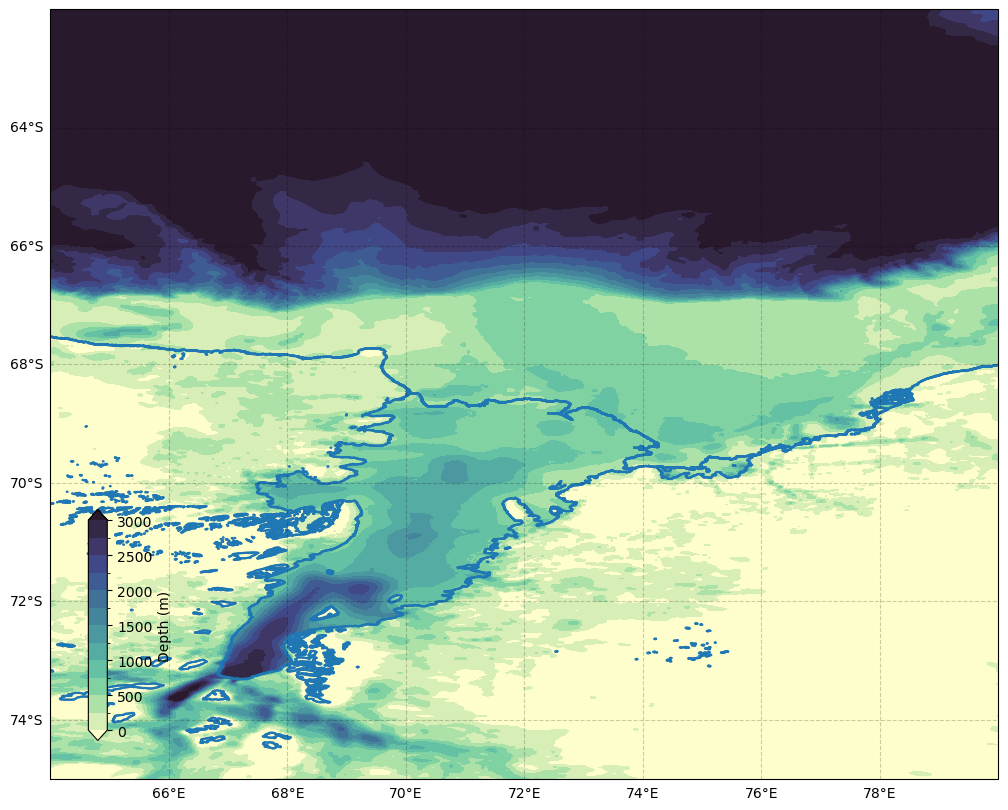

In [73]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

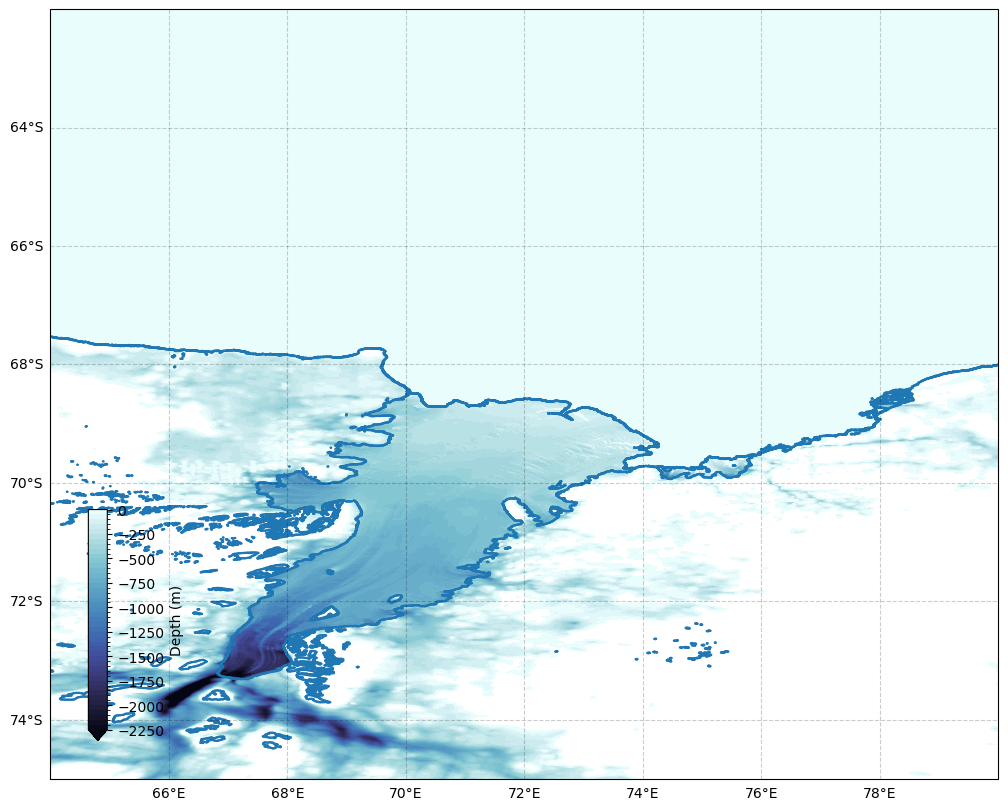

In [74]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


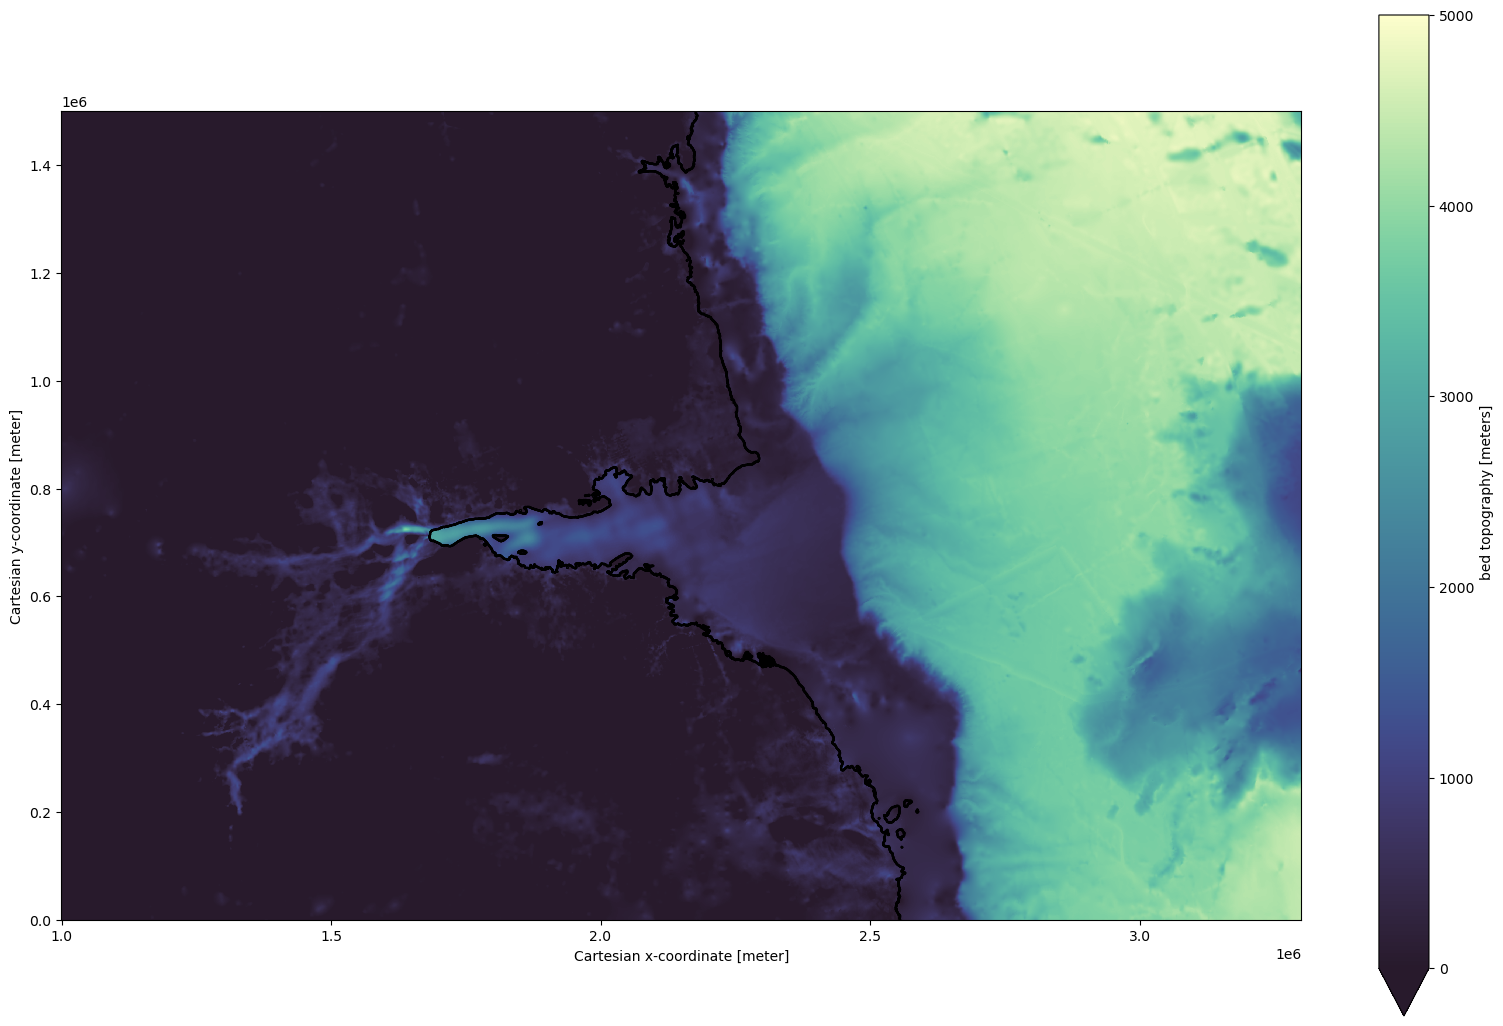

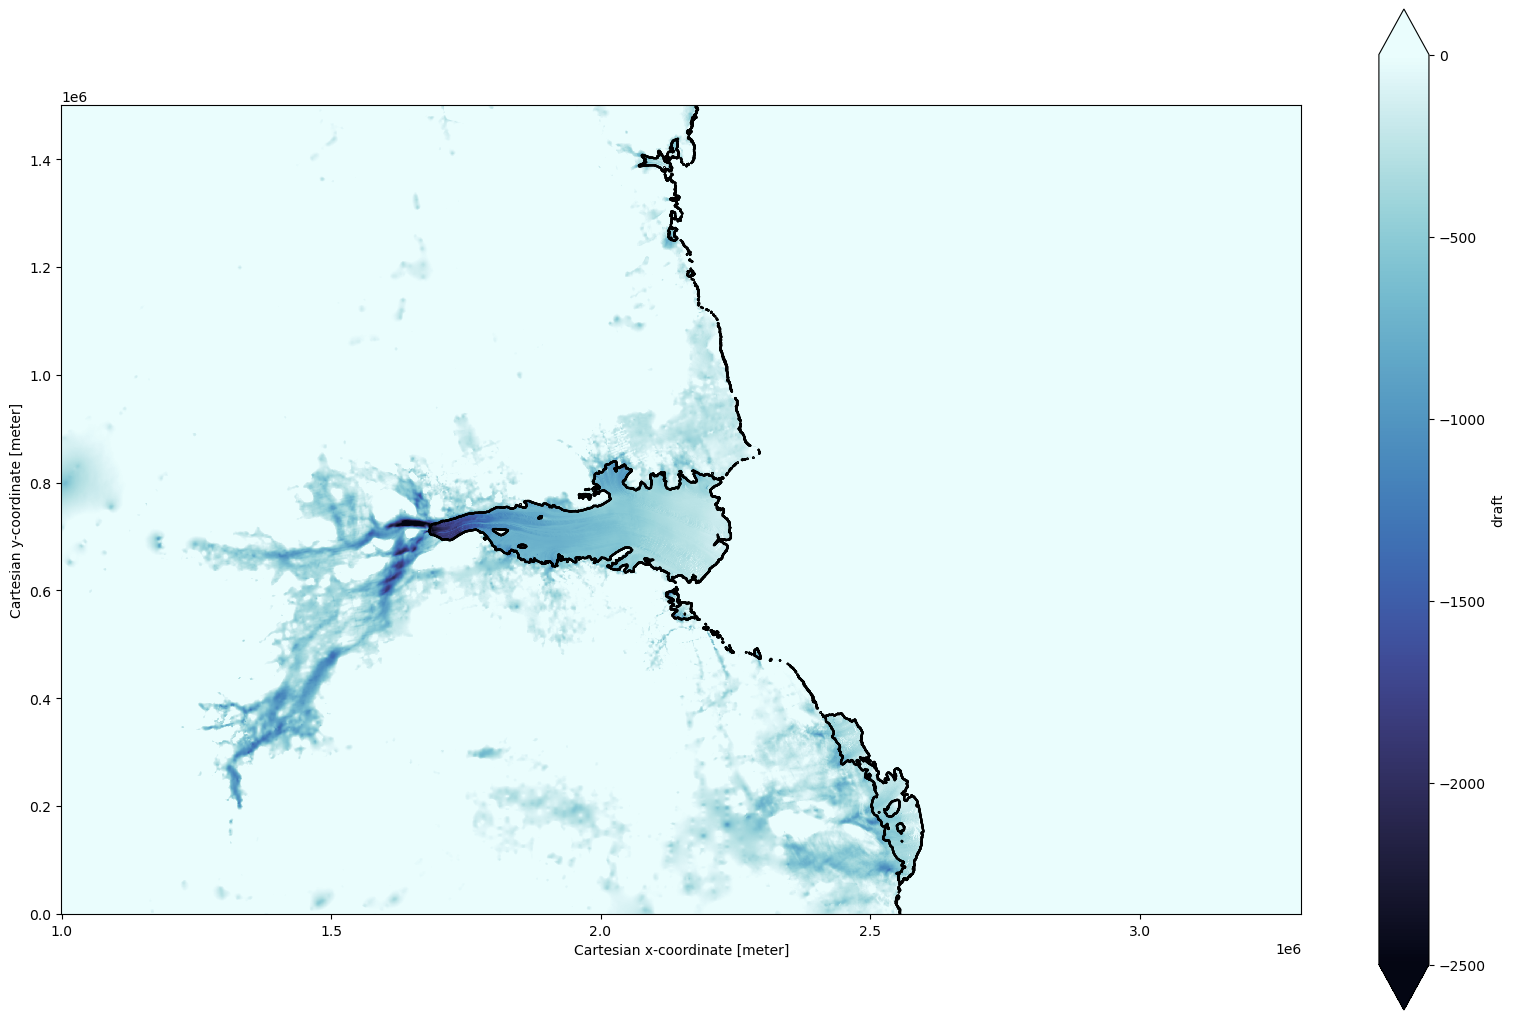

In [75]:
# plot of chosen subset
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.set_aspect('equal','box')

In [76]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [77]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [78]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated draft
interpolated mask_ice
interpolated mask_ocean


In [79]:
if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:80: RuntimeWarning: divide by zero encountered in divide
  hx = abs(h[:,1:] - h[:,:-1]) / (h[:,1:] + h[:,:-1])
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:81: RuntimeWarning: divide by zero encountered in divide
  hy = abs(h[1:,:] - h[:-1,:]) / (h[1:,:] + h[:-1,:])
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:83: RuntimeWarning: invalid value encountered in multiply
  hx = hx * umask
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:84: RuntimeWarning: invalid value encountered in multiply
  hy = hy * vmask


  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


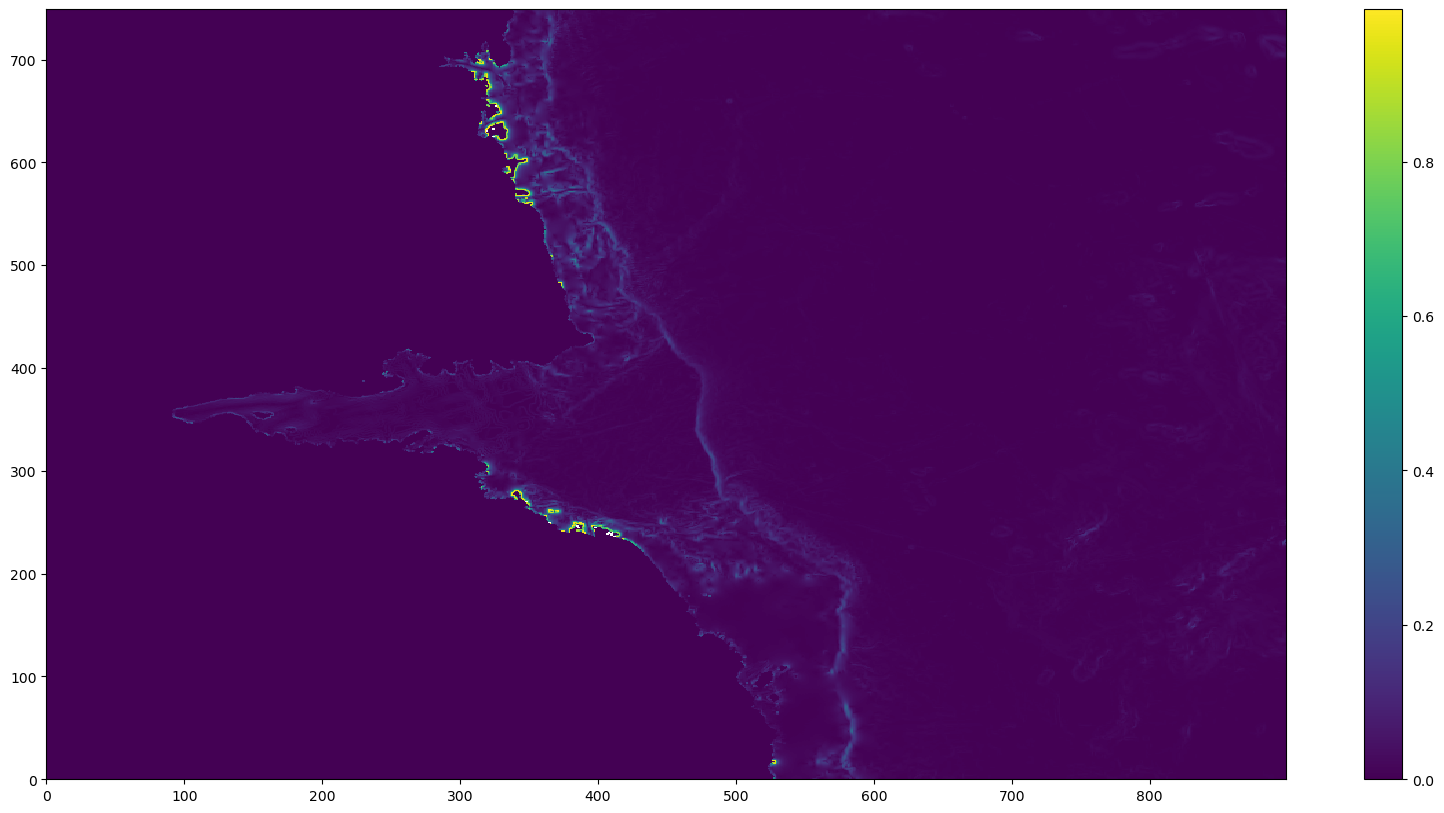

/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:141: RuntimeWarning: divide by zero encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:141: RuntimeWarning: invalid value encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:143: RuntimeWarning: divide by zero encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:143: RuntimeWarning: invalid value encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:145: RuntimeWarning: invalid value encountered in multiply
  zx[k,:] = zx[k,:] * umask
/home/wo

  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


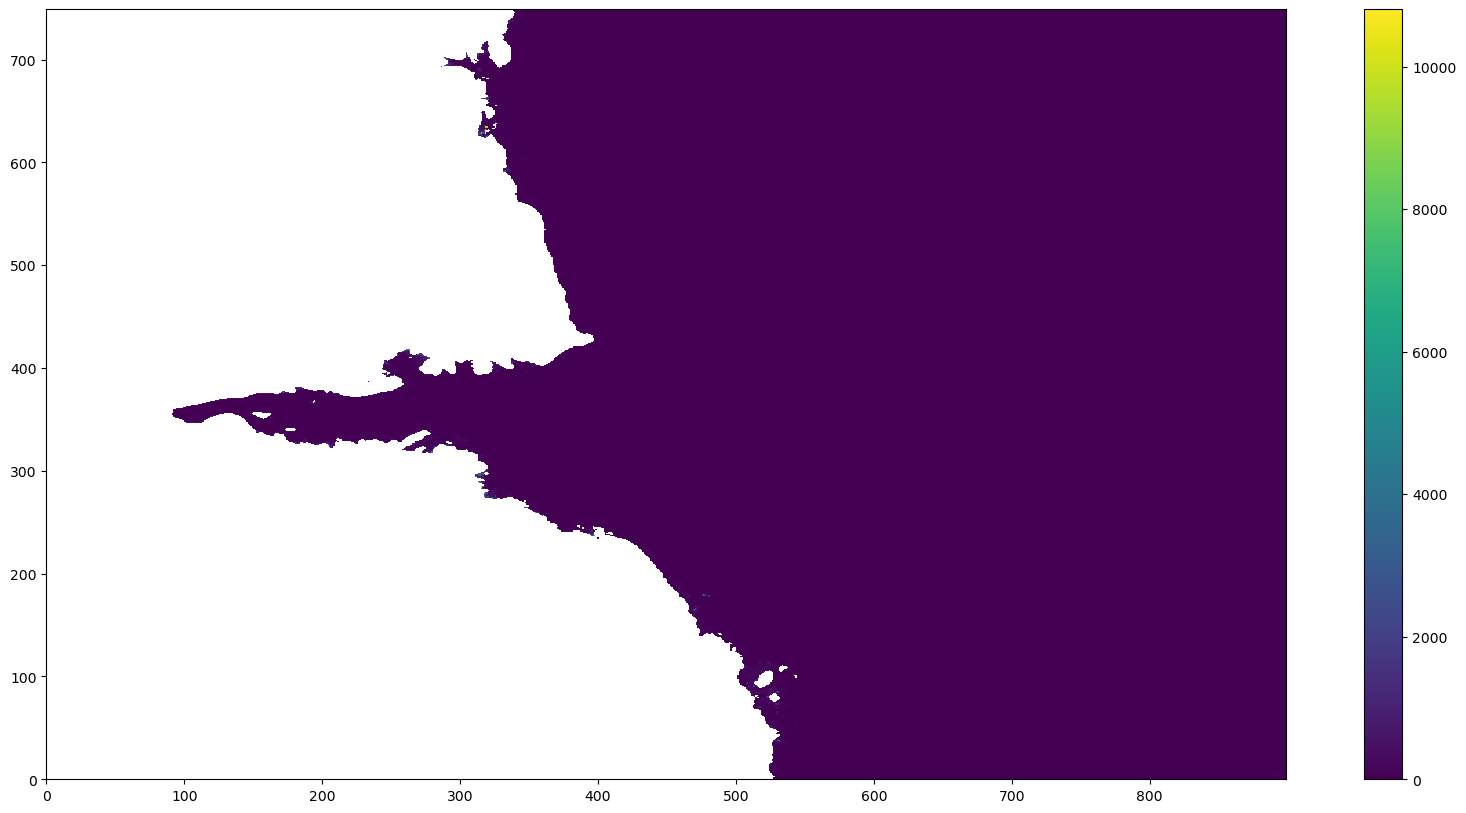

In [80]:


z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(20,10))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

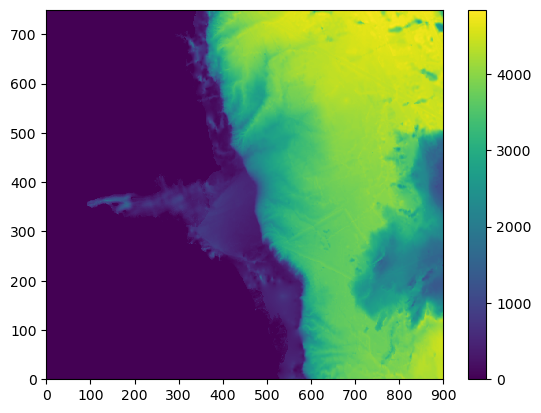

In [81]:
plt.pcolormesh(roms_tmp['bathy']+roms_tmp['draft'])
plt.colorbar()

In [82]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

min/max zice is -3799.7085 / 3080.7537
min/max h is -3080.7537 / 4838.785
min/max wct is 0.0 / 4838.785


In [83]:
# First round of smoothing

bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']

ice = roms_tmp['draft']

mask = roms_tmp['mask_ocean']
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
min_depth0=0.1
ice[ice>0] = 0
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
wct = bed + ice
ice[wct<min_depth0] = -bed[wct<min_depth0] + min_depth0  
wct = bed + ice

# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
rx0in = 0.3
max_iter = 100

Area = 1/(pm*pn)

wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)

ice = wct - bed

Old Max Roughness value is:  0.9998082518577576


DeltaBathymetry =  -231247.0
New Max Roughness value is:  0.30000582337379456
Old Max Roughness value is:  0.9998950958251953


DeltaBathymetry =  -778529.0
New Max Roughness value is:  0.3000057339668274


In [84]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

whole domain
min/max zice is -3799.6084 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.099975586 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 0.5207797884941101 / 4838.78515625
min/max wct is 0.33106938004493713 / 4838.78515625


In [85]:
# where ever the wct<min_depth, deepen the 

bed_smooth1 = bed.copy()
ice_smooth1 = ice.copy()
wct_smooth1 = bed.copy()+ice.copy()
min_depth = 50.0
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth
wct=bed+ice

In [86]:
# do checks
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

min/max zice is -3799.6084 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.099975586 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


  
Minimum r-value =  0.0
Maximum r-value =  0.33524036407470703
Mean    r-value =  0.00749179792698536
Median  r-value =  0.0009137133602052927


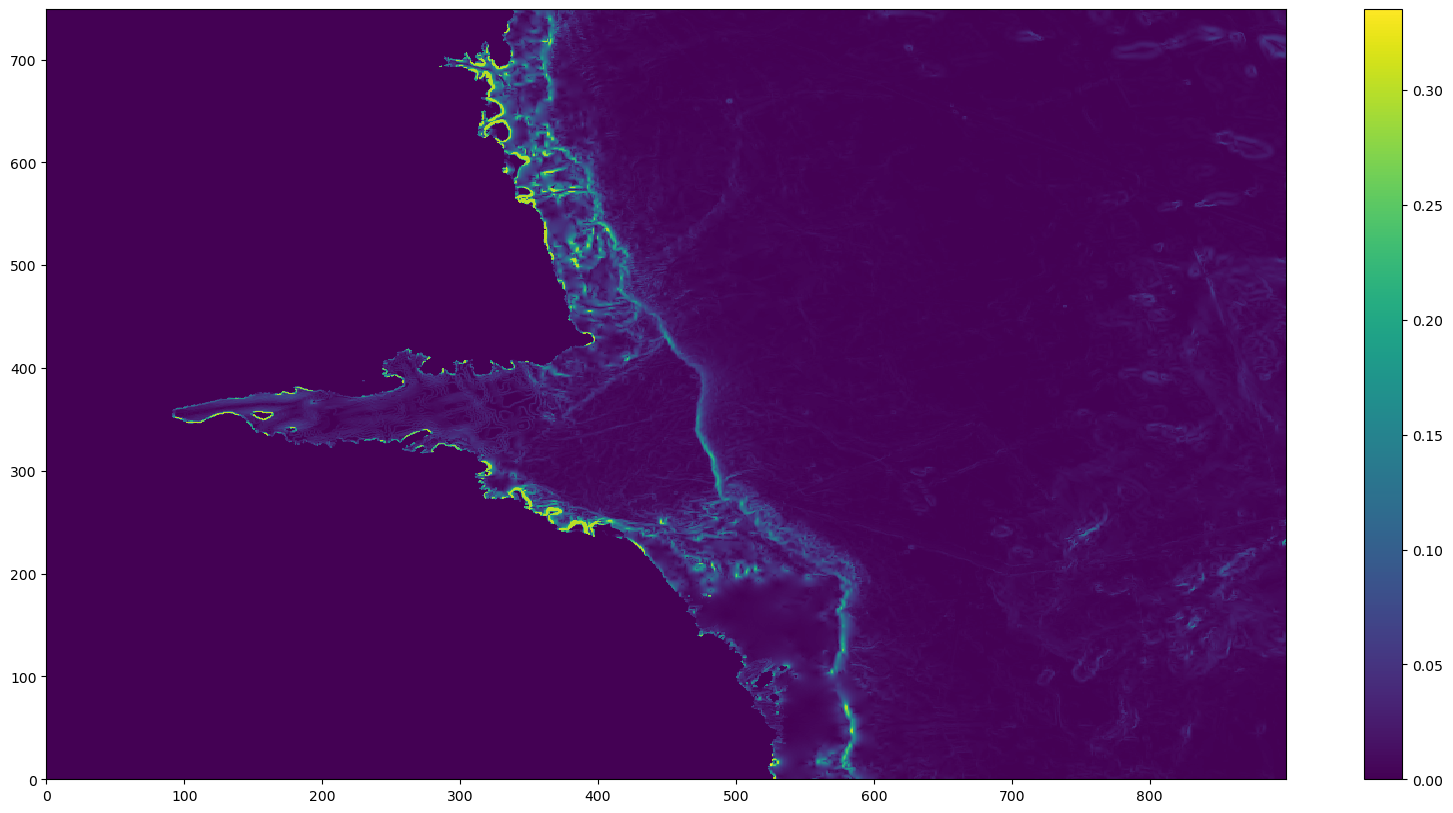

  
Minimum r-value =  0.0
Maximum r-value =  1437.6422133294718
Mean    r-value =  2.3416874776771133
Median  r-value =  0.24493435939305783


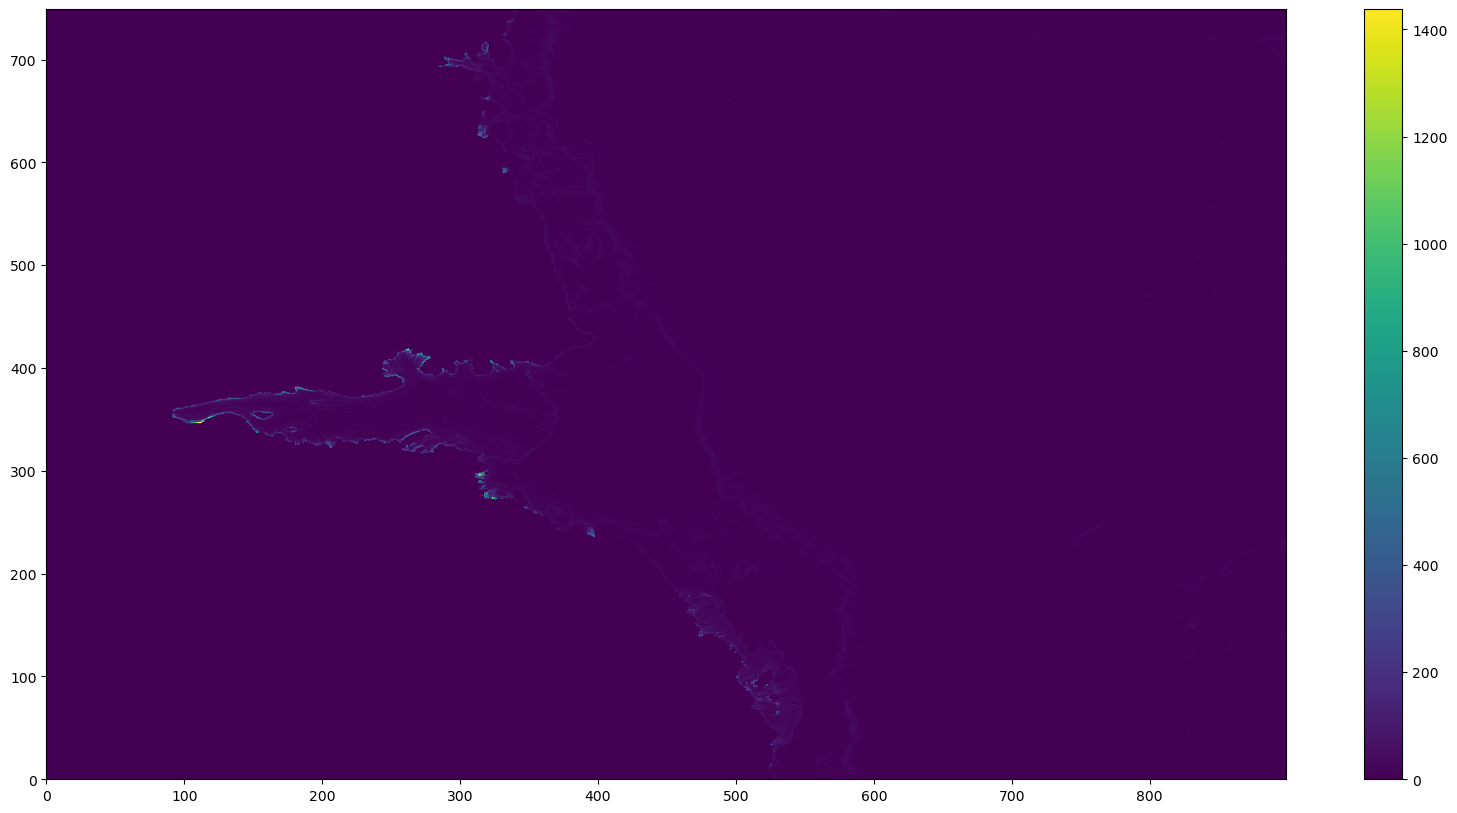

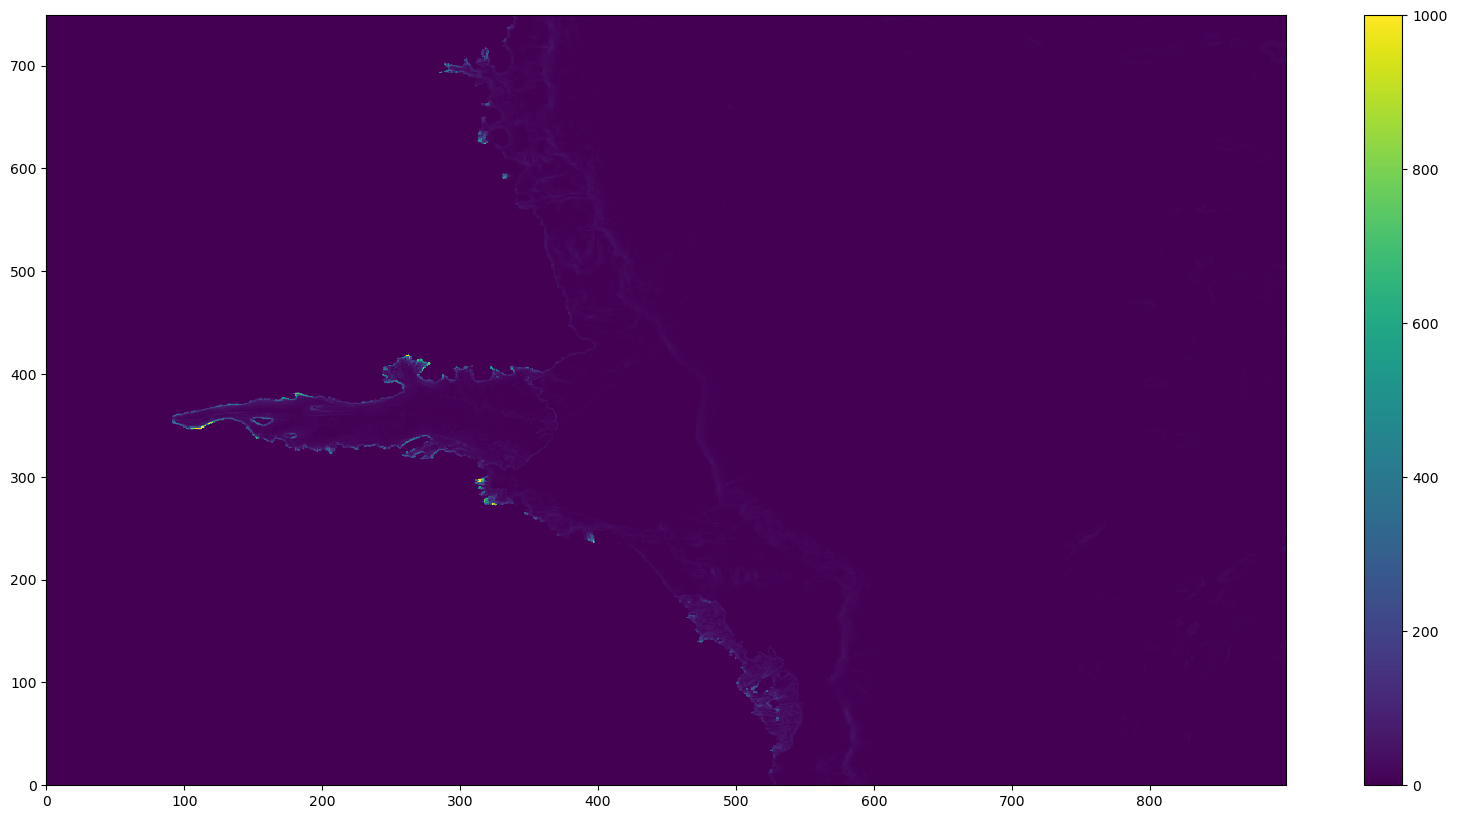

In [87]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=1000)
plt.colorbar()
plt.show()

In [88]:
# Second round of smoothing 
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)

ice = wct-bed

bed_smooth2 = bed.copy()
ice_smooth2 = ice.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

Old Max Roughness value is:  0.979418158531189


DeltaBathymetry =  -101839.5
New Max Roughness value is:  0.3000045120716095
Old Max Roughness value is:  0.9919247031211853


DeltaBathymetry =  -43049.0
New Max Roughness value is:  0.30000442266464233


In [89]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -3749.7085 / 49.9
min/max h is 0.1 / 4838.785
min/max wct is 49.99994 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


In [90]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

In [91]:
if plotting:
    plt.close()
    for k,v in roms_tmp.items():
        plt.figure(figsize=(5,3))
        print(k)
        plt.pcolormesh(v)
        plt.colorbar()
        plt.show()

In [92]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  8.67147445678711
max slow DT in s following CFL:  236.15961967599594
Set ROMS timestep settings of at least: 
 DT < 236.15961967599594 s 
 NDTFAST > 27.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.37158638959344
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8371586389593441


In [93]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -3749.7085 / 49.9
min/max h is 0.1 / 4838.785
min/max wct is 49.99994 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


  
Minimum r-value =  0.0
Maximum r-value =  0.34410360455513
Mean    r-value =  0.007505591123358341
Median  r-value =  0.000914283562451601


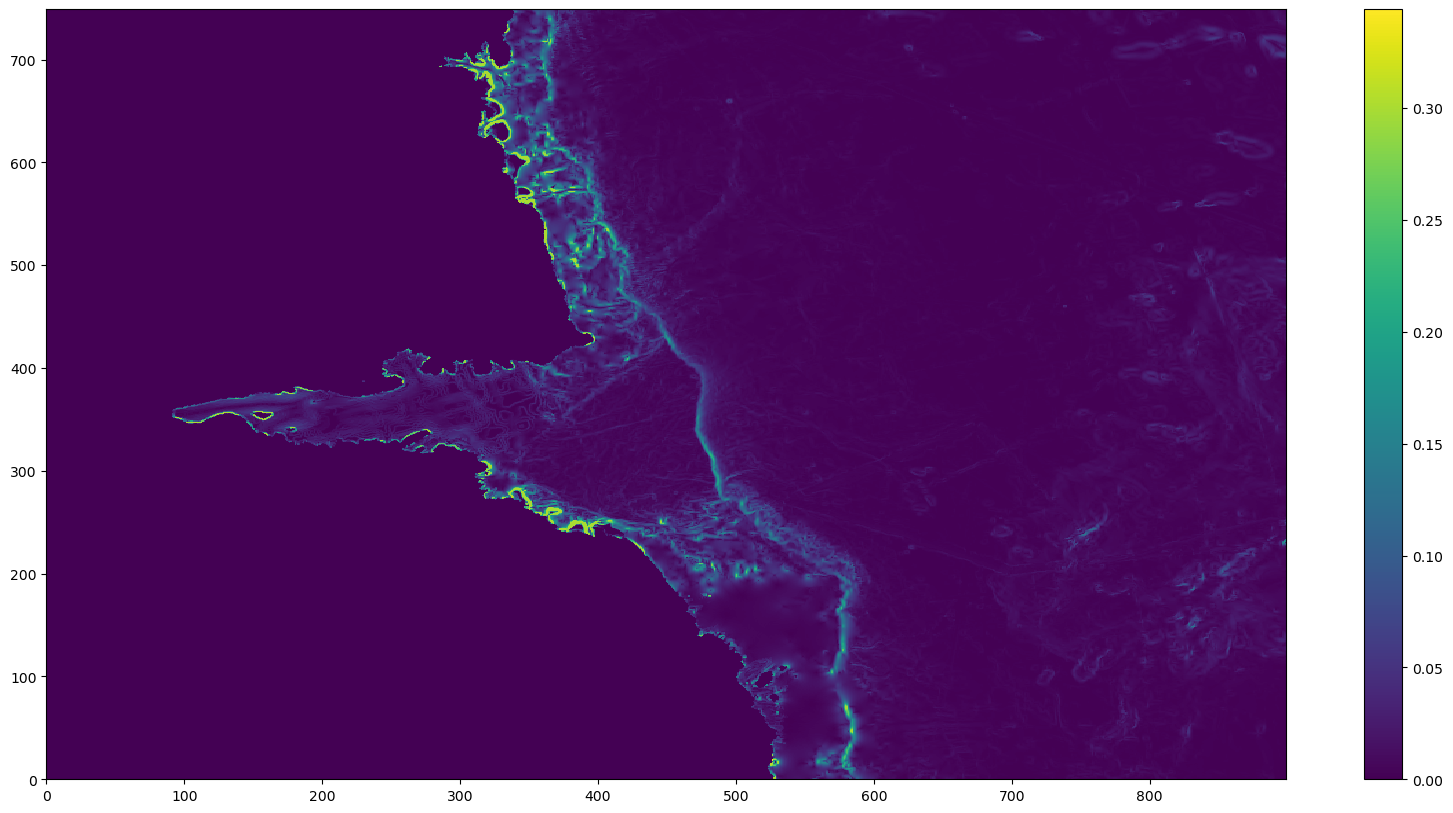

  
Minimum r-value =  0.0
Maximum r-value =  1437.6461493053887
Mean    r-value =  2.351474673464827
Median  r-value =  0.24512827731324616


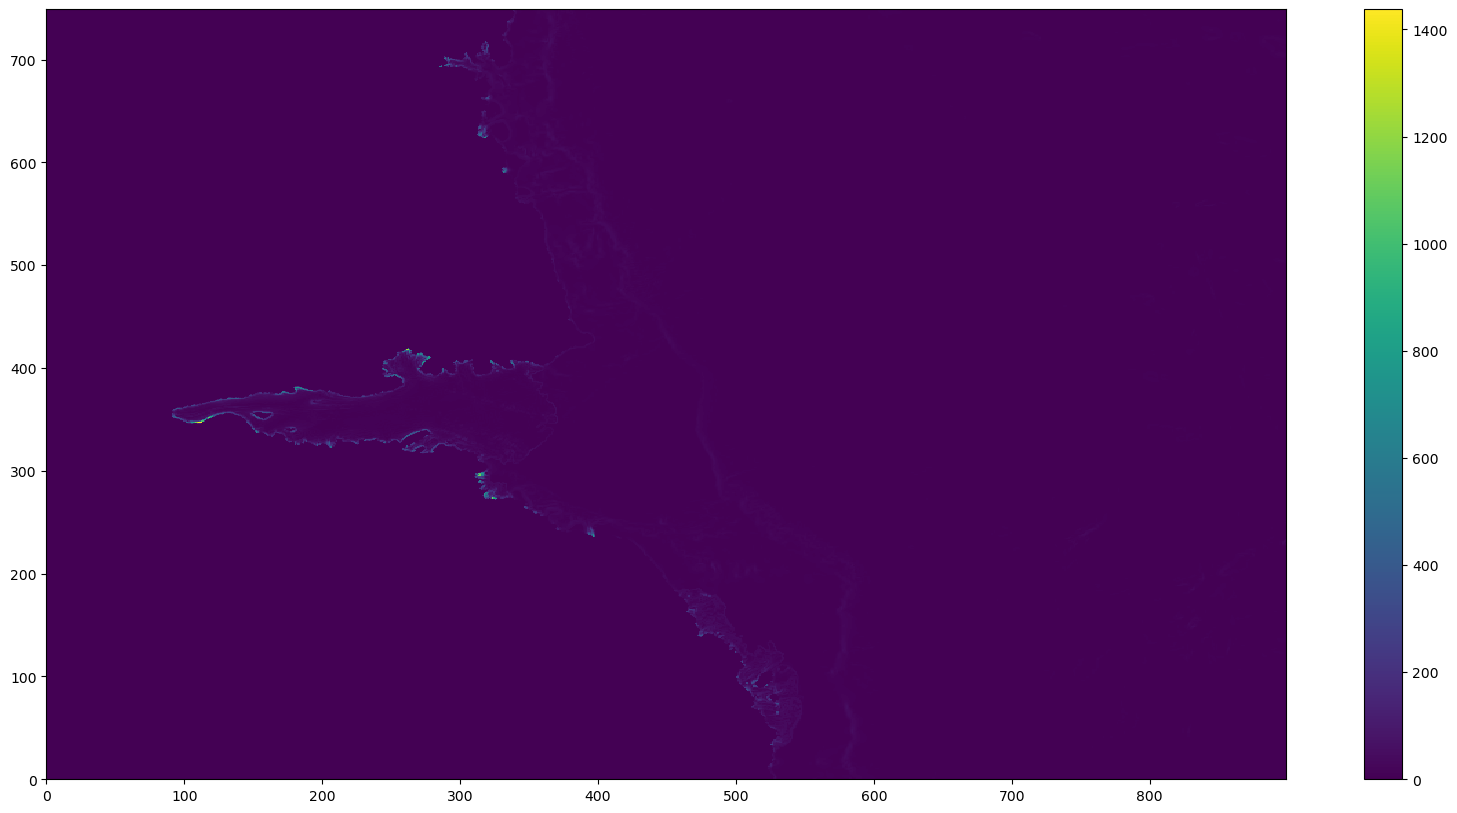

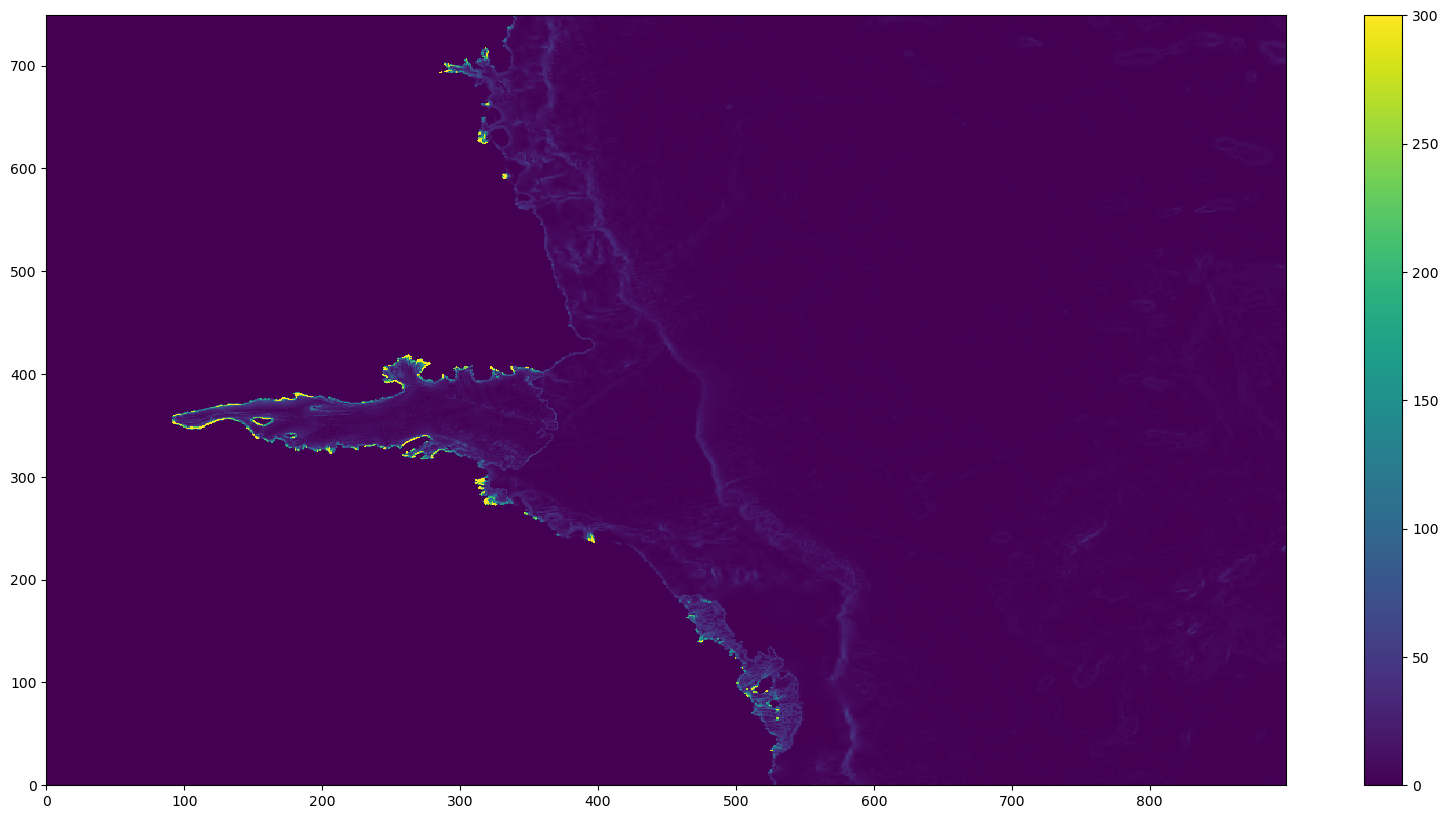

In [94]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=300)
plt.colorbar()
plt.show()

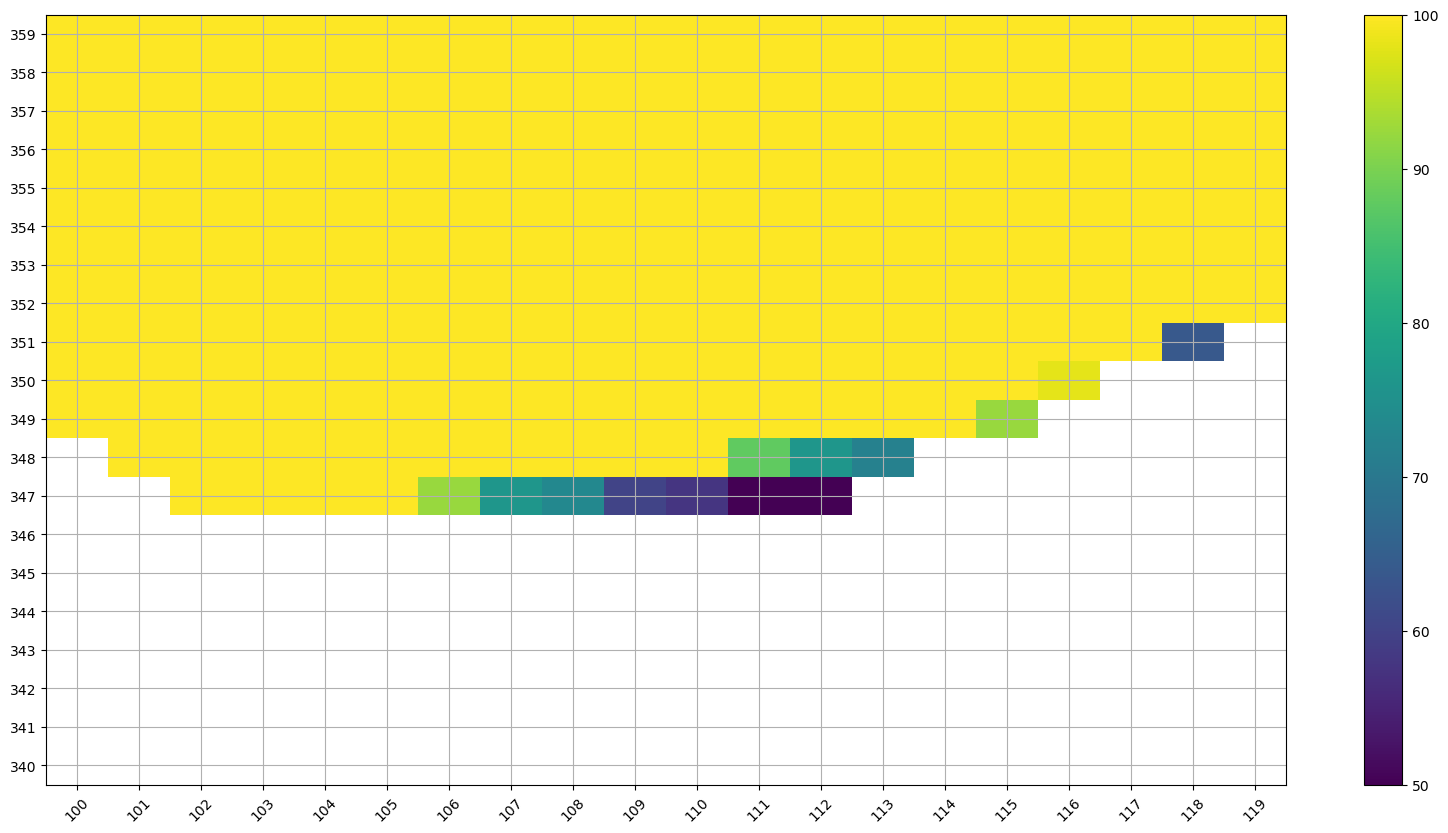

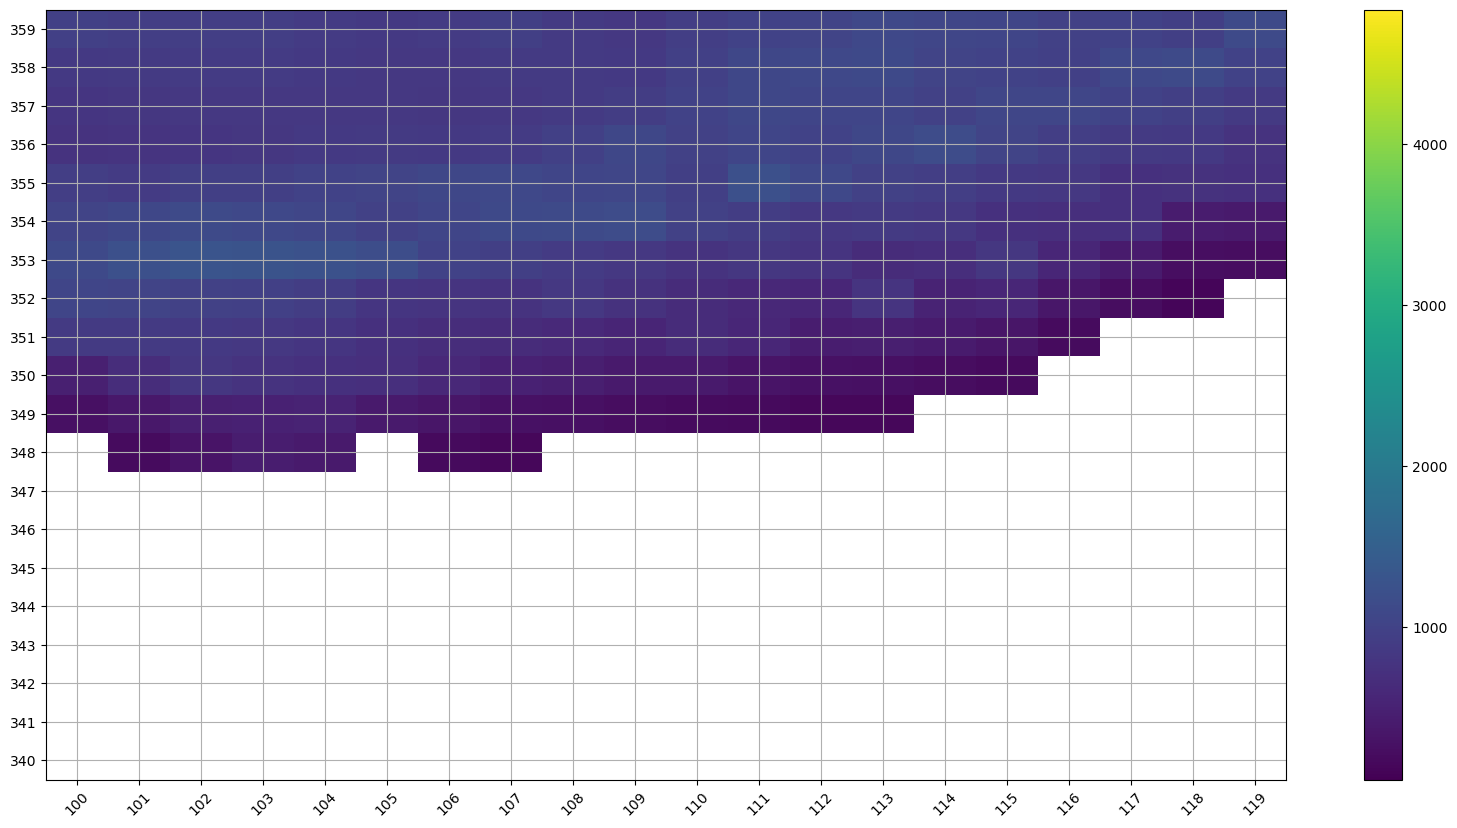

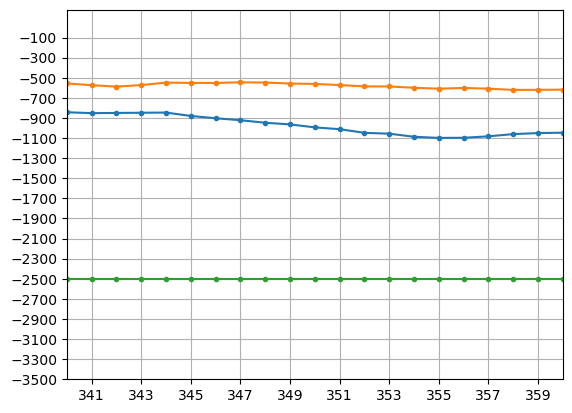

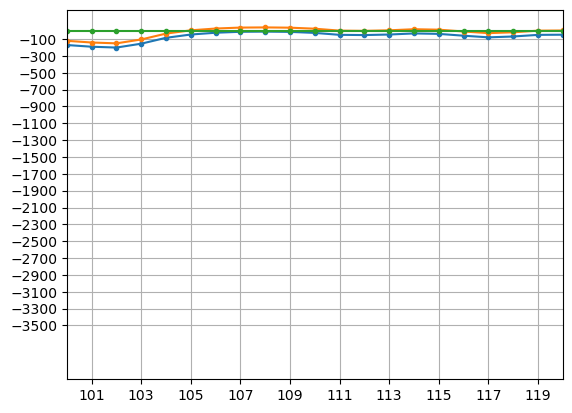

  
Minimum r-value =  0.0
Maximum r-value =  347.0628673955596
Mean    r-value =  2.024440124691328
Median  r-value =  0.2433974649574295
(27,)


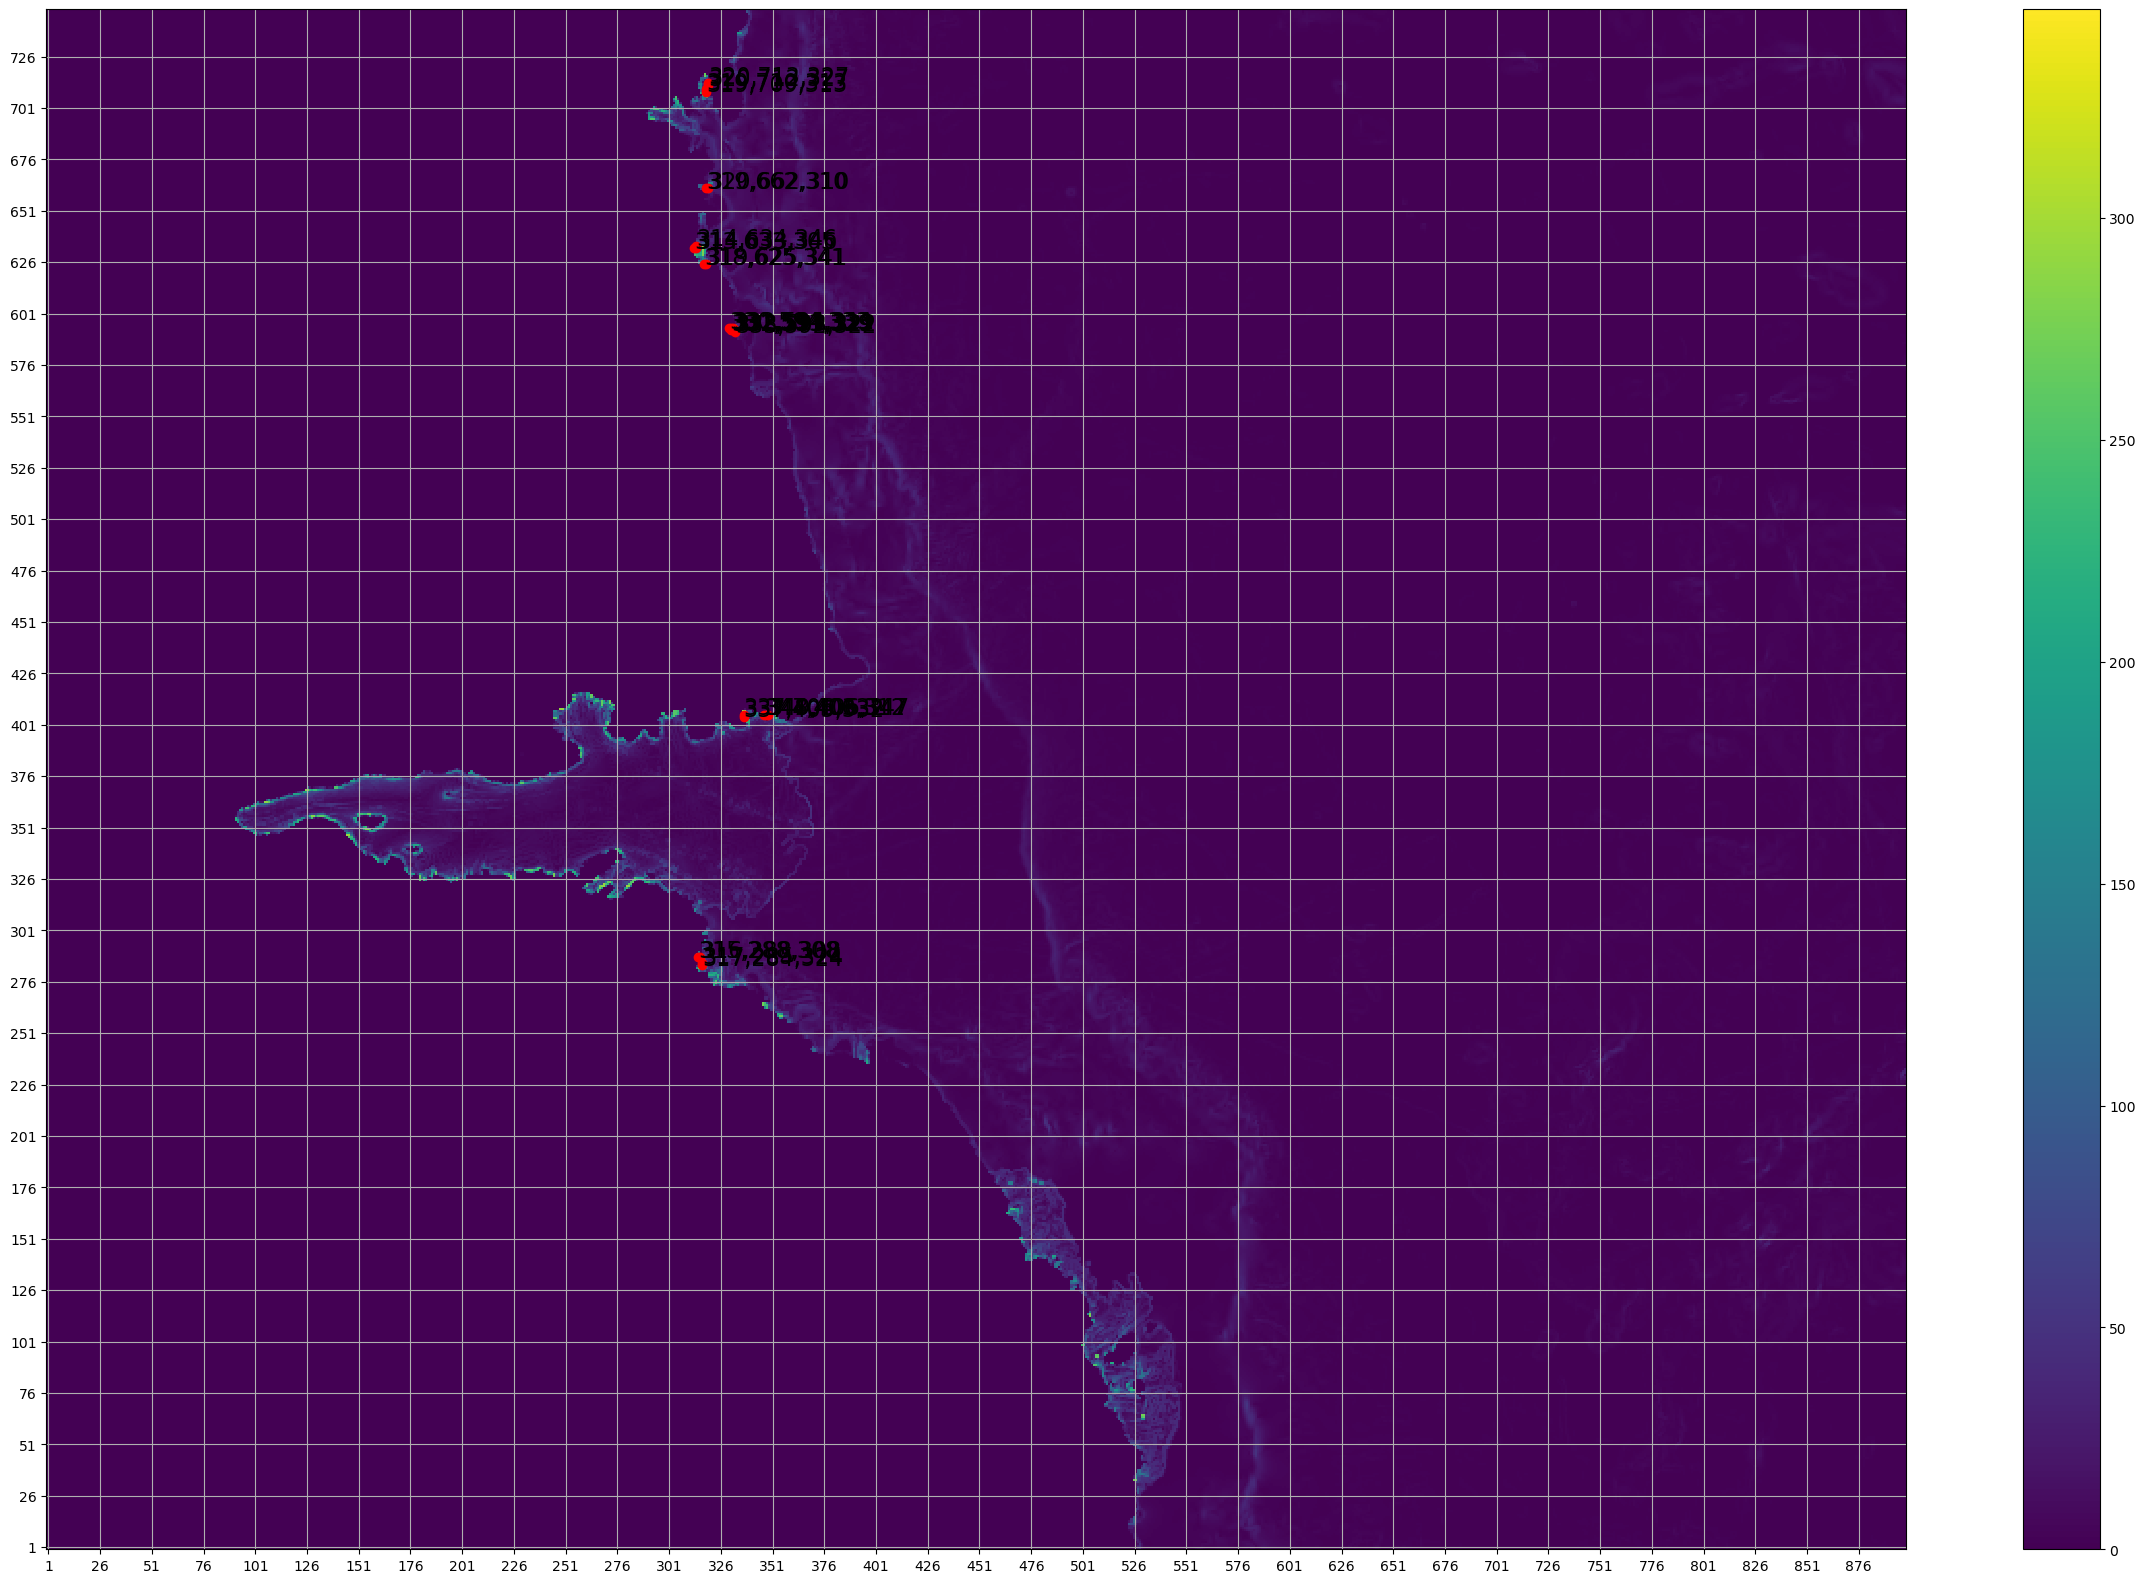

In [95]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!
# ensure that GridAdjustments functions are already loaded.

focusRange=(100,120,340,360)
seeBigPicture=True
searchForValrx1=300
# fig = plt.figure(figsize=(20,10))
# plt.pcolormesh(grd_rx1_post)
# plt.colorbar()
# plt.grid()
# plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xlim(focusRange[0],focusRange[1])
# plt.ylim(focusRange[2],focusRange[3])
# plt.show()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((roms_tmp['bed']+roms_tmp['ice'])*maskNaN,vmax=100)
plt.grid()
plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1),rotation=45)
# plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
plt.colorbar()
plt.xlim(focusRange[0],focusRange[1])
plt.ylim(focusRange[2],focusRange[3])
plt.show()


# plt.plot(-roms_tmp['bed'][:,396],'.-')
# plt.plot(roms_tmp['ice'][:,396],'.-')
# plt.plot(-1*roms_tmp['mask'][:,396]*2500,'.-')
# plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
# plt.yticks(np.arange(-3500,0,200))
# plt.xlim(220,260)
# plt.grid()
# plt.show()


hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

# remove a long string of very thin very steep border cells (basically cells on the edge of a subglacial mountain side; see above plots of bedrock)
mmm=adjustMask(mmm,0,eta=347,xi=112)
mmm=adjustMask(mmm,0,eta=347,xi=111)
mmm=adjustMask(mmm,0,eta=347,xi=110)
mmm=adjustMask(mmm,0,eta=347,xi=109)
mmm=adjustMask(mmm,0,eta=347,xi=108)
mmm=adjustMask(mmm,0,eta=347,xi=107)
mmm=adjustMask(mmm,0,eta=347,xi=106)
mmm=adjustMask(mmm,0,eta=347,xi=105)
mmm=adjustMask(mmm,0,eta=347,xi=104)
mmm=adjustMask(mmm,0,eta=347,xi=103)
mmm=adjustMask(mmm,0,eta=347,xi=102)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=500,zice_alter=-500,eta=352,xi=slice(91,94))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=300,zice_alter=-300,eta=351,xi=slice(94,96))
mmm=adjustMask(mmm,0,eta=361,xi=slice(95,97))
mmm=adjustMask(mmm,0,eta=351,xi=94)
mmm=adjustMask(mmm,0,eta=352,xi=93)
mmm=adjustMask(mmm,0,eta=slice(351,354),xi=92)
mmm=adjustMask(mmm,0,eta=350,xi=97)
mmm=adjustMask(mmm,0,eta=349,xi=99)
mmm=adjustMask(mmm,0,eta=351,xi=95)
mmm=adjustMask(mmm,0,eta=slice(358,360),xi=92)
mmm=adjustMask(mmm,0,eta=360,xi=93)

# tweak water column bordering on edge of mountain range on eastern GL.
hhh,zzz=adjustWCT(hhh,zzz,h_alter=250,zice_alter=-150,eta=348,xi=112)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=+50,eta=349,xi=112)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=350,xi=112)
mmm=adjustMask(mmm,0,eta=349,xi=slice(114,116))
mmm=adjustMask(mmm,0,eta=351,xi=slice(117,119))
mmm=adjustMask(mmm,0,eta=352,xi=slice(119,121))
mmm=adjustMask(mmm,0,eta=slice(347,349),xi=slice(112,116))
mmm=adjustMask(mmm,0,eta=slice(337,339),xi=slice(152,154))
mmm=adjustMask(mmm,0,eta=339,xi=152)
mmm=adjustMask(mmm,0,eta=348,xi=slice(108,113))
mmm=adjustMask(mmm,0,eta=348,xi=slice(108,113))
mmm=adjustMask(mmm,0,eta=350,xi=116)
mmm=adjustMask(mmm,0,eta=353,xi=slice(121,123))
mmm=adjustMask(mmm,0,eta=slice(322,324),xi=207)
mmm=adjustMask(mmm,0,eta=slice(322,329),xi=slice(204,210))
mmm=adjustMask(mmm,0,eta=328,xi=212)
mmm=adjustMask(mmm,0,eta=325,xi=197)
mmm=adjustMask(mmm,0,eta=354,xi=124)
mmm=adjustMask(mmm,0,eta=355,xi=slice(125,130))
# hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=348,xi=slice(106,107))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-200,eta=348,xi=slice(104,105))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=250,zice_alter=-250,eta=348,xi=slice(105,106))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=348,xi=slice(103,104))
mmm=adjustMask(mmm,0,eta=348,xi=105)



# tweak water column bordering on barely grounded western mid shelf.
mmm=adjustMask(mmm,0,eta=slice(379,383),xi=slice(181,189))
mmm=adjustMask(mmm,0,eta=slice(381,383),xi=slice(179,181))
mmm=adjustMask(mmm,0,eta=slice(376,379),xi=slice(169,177))
mmm=adjustMask(mmm,0,eta=slice(378,381),xi=slice(187,194))
mmm=adjustMask(mmm,0,eta=371,xi=139)
mmm=adjustMask(mmm,0,eta=348,xi=142)
mmm=adjustMask(mmm,0,eta=341,xi=150)
mmm=adjustMask(mmm,0,eta=354,xi=151)
mmm=adjustMask(mmm,0,eta=353,xi=152)
mmm=adjustMask(mmm,0,eta=352,xi=slice(153,155))
mmm=adjustMask(mmm,0,eta=356,xi=slice(157,163))
mmm=adjustMask(mmm,0,eta=354,xi=123)

# tweak water column bordering on weird ear shaped area on western mid shelf.
mmm=adjustMask(mmm,0,eta=slice(417,421),xi=slice(259,266))
mmm=adjustMask(mmm,0,eta=415,xi=slice(271,274))
mmm=adjustMask(mmm,0,eta=414,xi=slice(269,273))
mmm=adjustMask(mmm,0,eta=slice(410,412),xi=slice(277,279))
mmm=adjustMask(mmm,0,eta=409,xi=277)
mmm=adjustMask(mmm,0,eta=slice(404,408),xi=slice(273,275))
mmm=adjustMask(mmm,0,eta=416,xi=264)
mmm=adjustMask(mmm,0,eta=413,xi=slice(271,275))
mmm=adjustMask(mmm,0,eta=392,xi=254)
mmm=adjustMask(mmm,0,eta=393,xi=slice(251,254))
mmm=adjustMask(mmm,0,eta=392,xi=slice(250,252))
mmm=adjustMask(mmm,0,eta=slice(391,393),xi=255)
mmm=adjustMask(mmm,0,eta=391,xi=256)
mmm=adjustMask(mmm,0,eta=399,xi=287)
mmm=adjustMask(mmm,0,eta=slice(408,413),xi=slice(275,277))
mmm=adjustMask(mmm,0,eta=slice(387,398),xi=slice(242,250))
mmm=adjustMask(mmm,0,eta=slice(388,400),xi=slice(242,246))
mmm=adjustMask(mmm,0,eta=slice(398,410),xi=slice(242,246))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-0,eta=slice(400,407),xi=slice(245,250))
mmm=adjustMask(mmm,0,eta=398,xi=246)
mmm=adjustMask(mmm,0,eta=413,xi=270)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-0,eta=slice(398,401),xi=slice(269,271))
mmm=adjustMask(mmm,0,eta=412,xi=274)
mmm=adjustMask(mmm,0,eta=371,xi=slice(132,139))
mmm=adjustMask(mmm,0,eta=327,xi=slice(245,247))
mmm=adjustMask(mmm,0,eta=slice(316,321),xi=slice(279,281))
mmm=adjustMask(mmm,0,eta=328,xi=293)
mmm=adjustMask(mmm,0,eta=slice(406,408),xi=slice(296,298))
mmm=adjustMask(mmm,0,eta=405,xi=296)
mmm=adjustMask(mmm,0,eta=399,xi=slice(287,289))
mmm=adjustMask(mmm,0,eta=slice(397,399),xi=287)
mmm=adjustMask(mmm,0,eta=369,xi=slice(123,125))
mmm=adjustMask(mmm,0,eta=slice(239,331),xi=231)
mmm=adjustMask(mmm,0,eta=320,xi=slice(259,262))
mmm=adjustMask(mmm,0,eta=321,xi=slice(258,260))
mmm=adjustMask(mmm,0,eta=319,xi=slice(265,267))
mmm=adjustMask(mmm,0,eta=390,xi=257)



# tweak cells on east side of amery mid shelf
mmm=adjustMask(mmm,0,eta=329,xi=267)
mmm=adjustMask(mmm,0,eta=slice(382,395),xi=slice(232,241))
mmm=adjustMask(mmm,0,eta=slice(332,335),xi=slice(260,264))
mmm=adjustMask(mmm,0,eta=324,xi=261)
mmm=adjustMask(mmm,0,eta=322,xi=256)
mmm=adjustMask(mmm,0,eta=slice(328,332),xi=slice(258,260))
mmm=adjustMask(mmm,0,eta=slice(334,337),xi=slice(263,276))
mmm=adjustMask(mmm,0,eta=slice(335,338),xi=slice(265,269))
mmm=adjustMask(mmm,0,eta=slice(337,339),xi=slice(267,272))
mmm=adjustMask(mmm,0,eta=319,xi=267)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=200,zice_alter=-150,eta=375,xi=slice(167,170))
mmm=adjustMask(mmm,0,eta=376,xi=slice(177,179))
mmm=adjustMask(mmm,0,eta=slice(377,379),xi=181)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-110,eta=339,xi=179)
mmm=adjustMask(mmm,0,eta=340,xi=slice(272,276))

# tweak remove cells below tiny ice shelves just east of amery
mmm=adjustMask(mmm,0,eta=slice(287,300),xi=slice(309,315))
mmm=adjustMask(mmm,0,eta=slice(273,275),xi=slice(323,327))
mmm=adjustMask(mmm,0,eta=slice(273,279),xi=slice(316,318))
mmm=adjustMask(mmm,0,eta=slice(291,300),xi=slice(314,318))
mmm=adjustMask(mmm,0,eta=slice(272,280),xi=slice(316,320))
mmm=adjustMask(mmm,0,eta=slice(274,278),xi=slice(319,322))
mmm=adjustMask(mmm,0,eta=slice(278,279),xi=320)

# add sorsdal back in
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(243,247),xi=slice(391,394))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(236,244),xi=slice(391,397))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(242,245),xi=slice(394,397))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(238,242),xi=396)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(238,242),xi=397)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=237,xi=slice(397,400))

# tweak remove cells below tiny ice shelves west of amery
mmm=adjustMask(mmm,0,eta=slice(591,593),xi=slice(331,333))
mmm=adjustMask(mmm,0,eta=624,xi=slice(317,319))
mmm=adjustMask(mmm,0,eta=slice(623,629),xi=slice(312,316))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(628,630),xi=slice(315,317))
mmm=adjustMask(mmm,0,eta=slice(691,706),xi=slice(286,291))
mmm=adjustMask(mmm,0,eta=702,xi=slice(291,293))
mmm=adjustMask(mmm,0,eta=slice(699,702),xi=slice(310,312))
mmm=adjustMask(mmm,0,eta=slice(694,696),xi=slice(291,293))
mmm=adjustMask(mmm,0,eta=701,xi=291)
mmm=adjustMask(mmm,0,eta=694,xi=slice(292,301))
mmm=adjustMask(mmm,0,eta=slice(700,702),xi=slice(291,293))

# tweak cells in 're-entrant' branches of amery west side
mmm=adjustMask(mmm,0,eta=slice(406,412),xi=slice(320,328))
mmm=adjustMask(mmm,0,eta=slice(409,412),xi=slice(336,340))
mmm=adjustMask(mmm,0,eta=405,xi=323)
mmm=adjustMask(mmm,0,eta=slice(404,406),xi=slice(337,339))
mmm=adjustMask(mmm,0,eta=slice(403,412),xi=slice(323,330))

# tiny ice shelf far east of amery
mmm=adjustMask(mmm,0,eta=slice(138,141),xi=473)
mmm=adjustMask(mmm,0,eta=139,xi=slice(474,476))
mmm=adjustMask(mmm,0,eta=slice(139,141),xi=slice(475,477))
mmm=adjustMask(mmm,0,eta=124,xi=slice(498,501))
mmm=adjustMask(mmm,0,eta=slice(87,89),xi=slice(508,510))
mmm=adjustMask(mmm,0,eta=slice(92,94),xi=slice(522,524))
mmm=adjustMask(mmm,0,eta=slice(93,97),xi=slice(513,517))
mmm=adjustMask(mmm,0,eta=slice(92,95),xi=slice(511,515))
mmm=adjustMask(mmm,0,eta=91,xi=slice(512,515))
mmm=adjustMask(mmm,0,eta=67,xi=slice(530,532))
mmm=adjustMask(mmm,0,eta=slice(71,74),xi=slice(529,531))
mmm=adjustMask(mmm,0,eta=slice(73,76),xi=slice(531,532))
mmm=adjustMask(mmm,0,eta=slice(73,76),xi=slice(529,531))




mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((roms_tmp['bed']+roms_tmp['ice'])*mmmNaN)
plt.grid()
plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1),rotation=45)
# plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
plt.colorbar()
plt.xlim(focusRange[0],focusRange[1])
plt.ylim(focusRange[2],focusRange[3])
plt.show()

# look along a single xi value
lookAt=260
plt.plot(-hhh[:,lookAt],'.-')
plt.plot(zzz[:,lookAt],'.-')
plt.plot(-1*mmm[:,lookAt]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.xlim(focusRange[2],focusRange[3])
plt.grid()
plt.show()

# look along a single eta value
lookAt=320
plt.plot(-hhh[lookAt,:],'.-')
plt.plot(zzz[lookAt,:],'.-')
plt.plot(-1*mmm[lookAt,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.xlim(focusRange[0],focusRange[1])
plt.grid()
plt.show()



z_rho_test,z_w_test,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx1_test=GridStiffness.rx1(z_w_test,mmm)
max_vals_vals=grd_rx1_test[grd_rx1_test>searchForValrx1]
max_vals_y,max_vals_x=np.nonzero(grd_rx1_test>searchForValrx1)
print(max_vals_vals.shape)
fig = plt.figure(figsize=(30,20))
plt.pcolormesh(grd_rx1_test)
plt.grid()
plt.plot(max_vals_x,max_vals_y,'ro')

if seeBigPicture==False:
    plt.yticks(np.arange(1,750,1),np.arange(1.5,750,1))
    plt.xticks(np.arange(1,900,1),np.arange(1.5,900,1),rotation=45)
    plt.xlim(focusRange[0],focusRange[1])
    plt.ylim(focusRange[2],focusRange[3])
else:
    plt.yticks(np.arange(1,750,25),np.arange(1,750,25))
    plt.xticks(np.arange(1,900,25),np.arange(1,900,25))
    for x,y,t in zip(max_vals_x,max_vals_y,max_vals_vals):
        plt.text(x,y,str(x)+','+str(y)+','+str(round(t)),ha='left',fontsize=16)
plt.colorbar()
plt.show()


In [96]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mmm)

mmm_noSS = mmm.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mmm = mmm_noSS

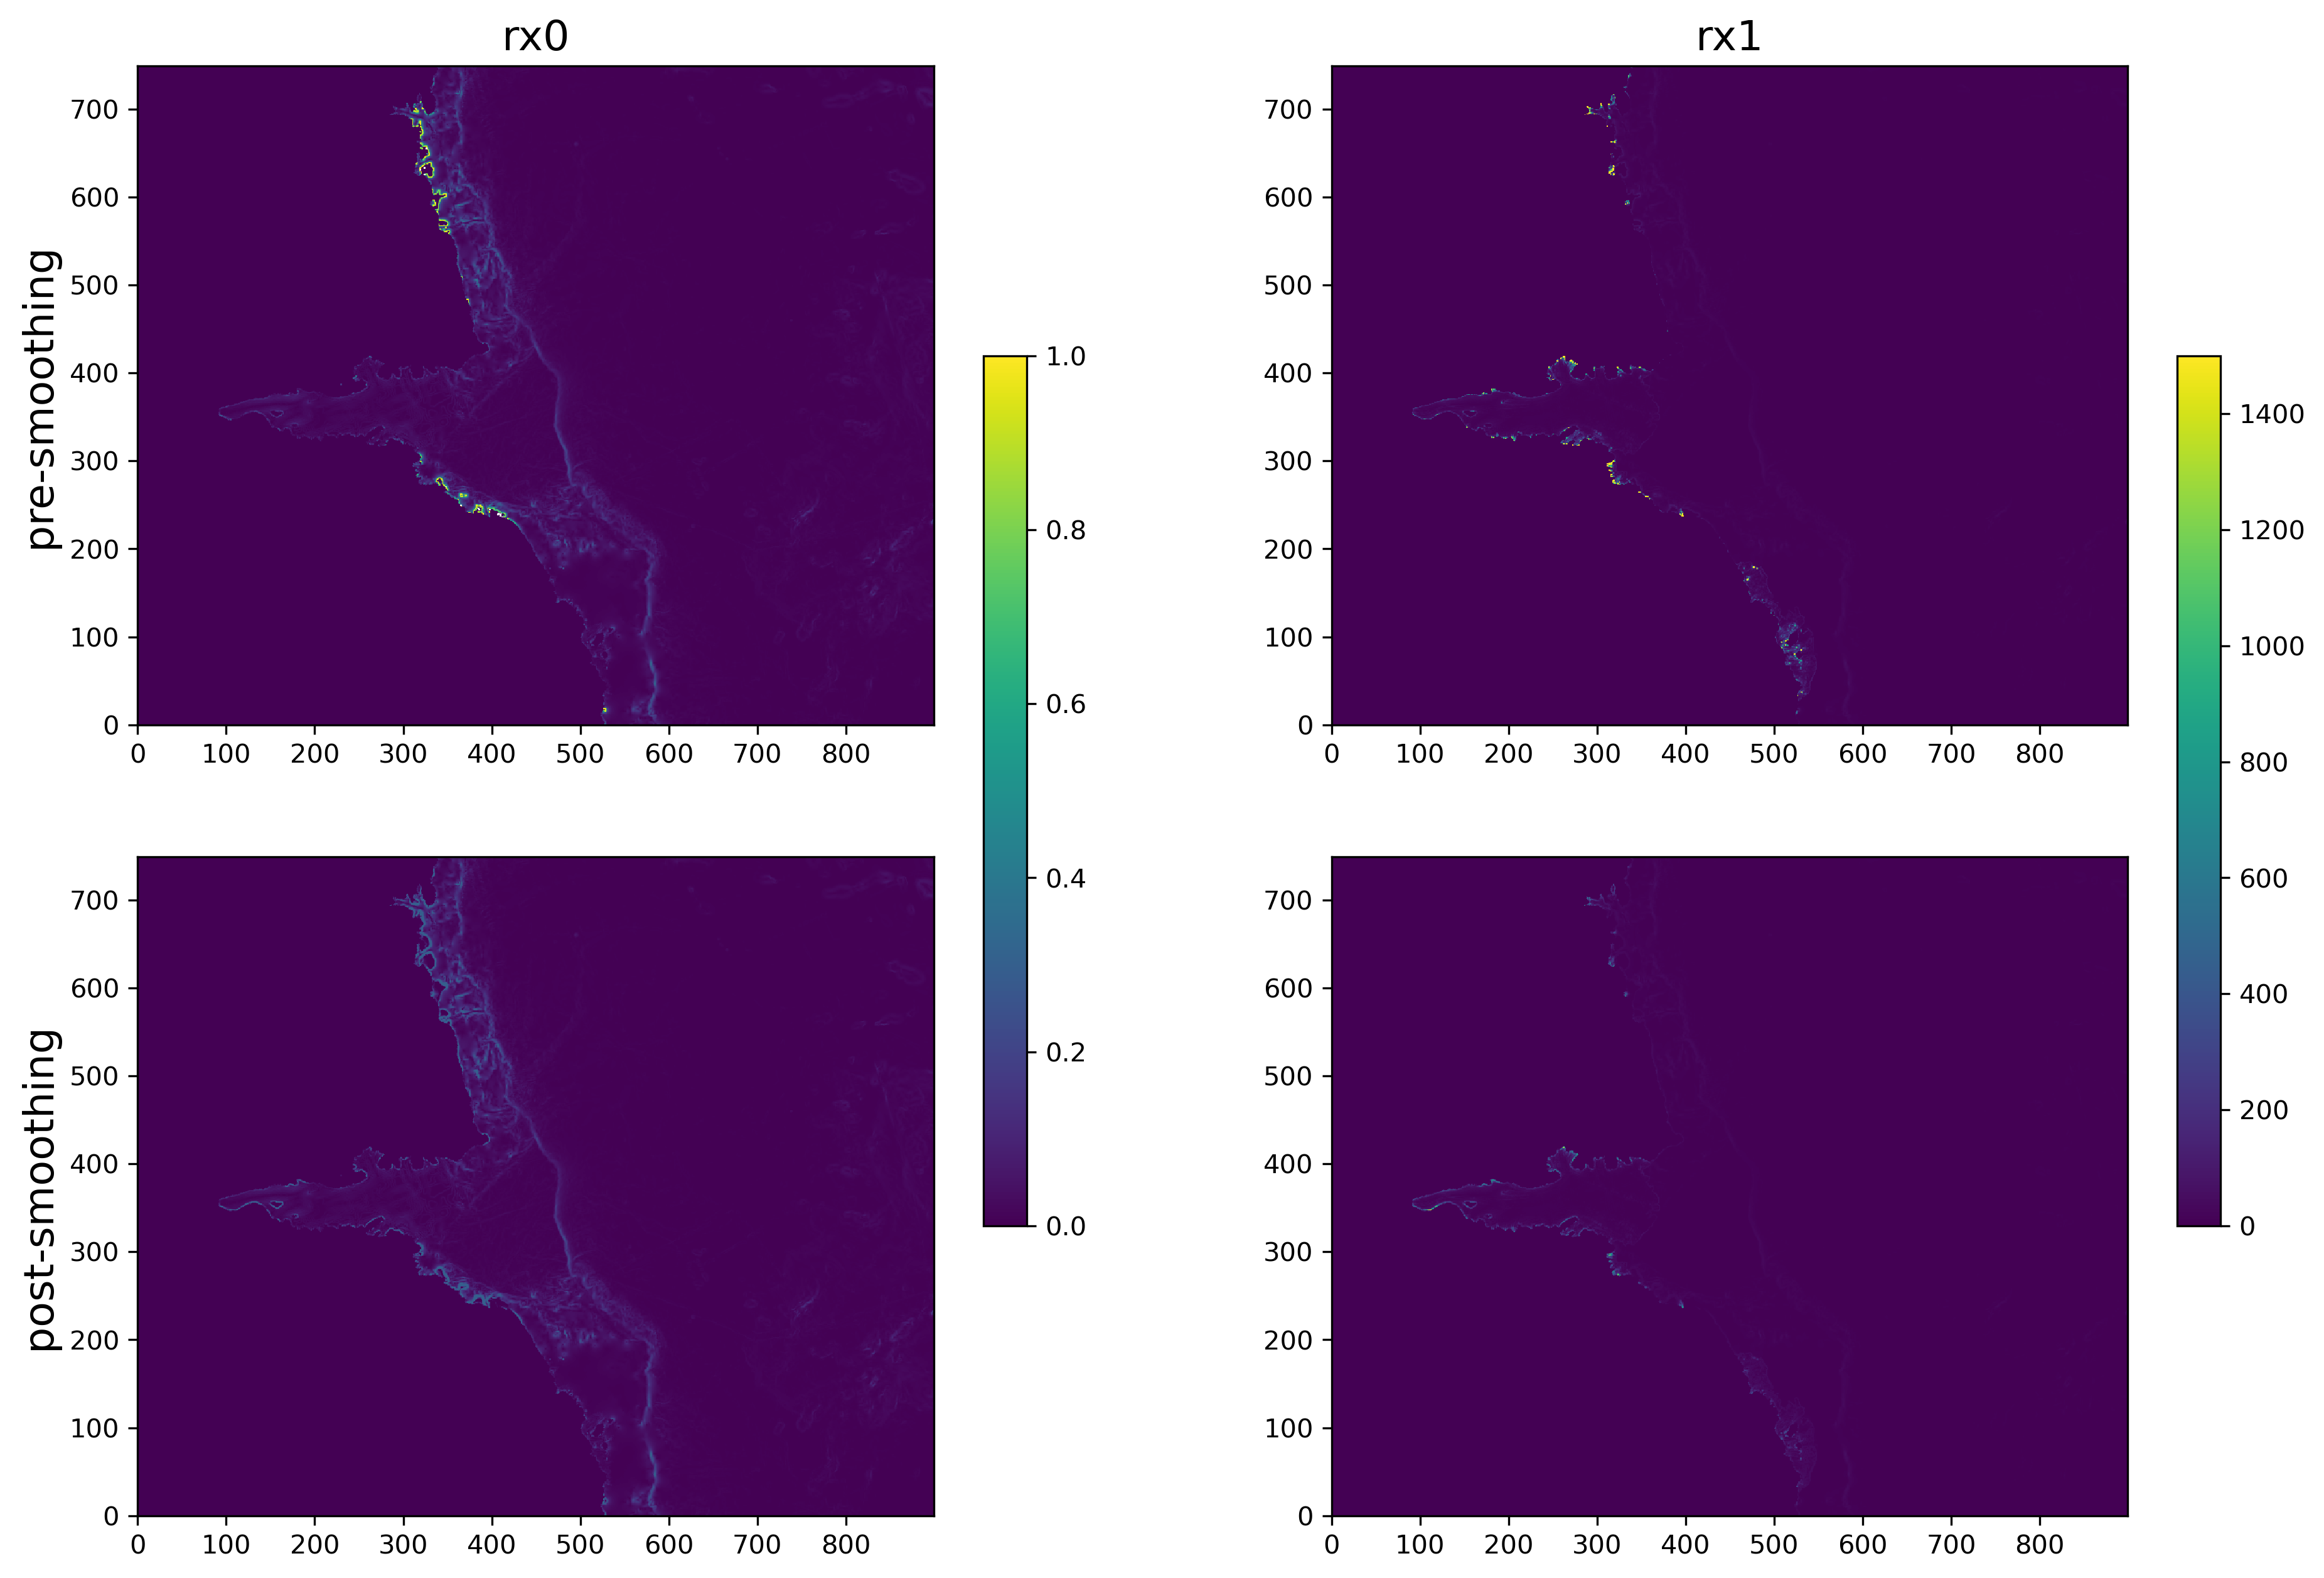

In [97]:

fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_post,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_post,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

In [98]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_final=GridStiffness.rx0(hhh,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)


  
Minimum r-value =  0.0
Maximum r-value =  0.6946612596511841
Mean    r-value =  0.007371154527573977
Median  r-value =  0.000907407549675554
  
Minimum r-value =  0.0
Maximum r-value =  347.0628673955596
Mean    r-value =  2.024440124691328
Median  r-value =  0.2433974649574295


In [99]:
# third round of smoothing, pulling rx0 down to something more reasonable
hhh_final, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),hhh,rx0in,Area,max_iter)
zzz_final = zzz.copy()
# now re-check that min_depth is obeyed for all ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mask == 1)
hhh_final[ii] = -zzz_final[ii] + min_depth

# do the same for all non-ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mask == 0)
zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy


Old Max Roughness value is:  0.814640998840332


DeltaBathymetry =  -74689.5
New Max Roughness value is:  0.3000045120716095


In [100]:
# remove any zice that is >0.
zzz_final_backup = zzz_final.copy()

anyPosZice=np.any(zzz_final>0)

if anyPosZice:
    new_ice = zzz_final.copy()
    new_ice[(zzz_final>0)]=0
    zzz_final=new_ice.copy()


In [101]:
maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
print('min/max h is',hhh_final.min(),'/',hhh_final.max())
print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

whole domain
min/max zice is -3749.7085 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.1 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


In [102]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh_final,zzz_final)
grd_rx0_final=GridStiffness.rx0(hhh_final,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)



  
Minimum r-value =  0.0
Maximum r-value =  0.31513404846191406
Mean    r-value =  0.007370767177809406
Median  r-value =  0.000907407549675554
  
Minimum r-value =  0.0
Maximum r-value =  347.0628673955596
Mean    r-value =  2.025778647855193
Median  r-value =  0.2433974649574295


[323.51880243 323.51880243 308.30375464 308.30375464 331.79796172
 331.79796172 312.09225347 347.0628674  347.0628674  322.00112464
 328.69767868 328.69767868 322.00112464 332.66064011 332.66064011
 311.29316975 341.16073707 341.16073707 304.75914316 345.96237348
 345.96237348 309.86238064 309.86238064 313.18102959 313.18102959
 326.72941634 326.72941634]


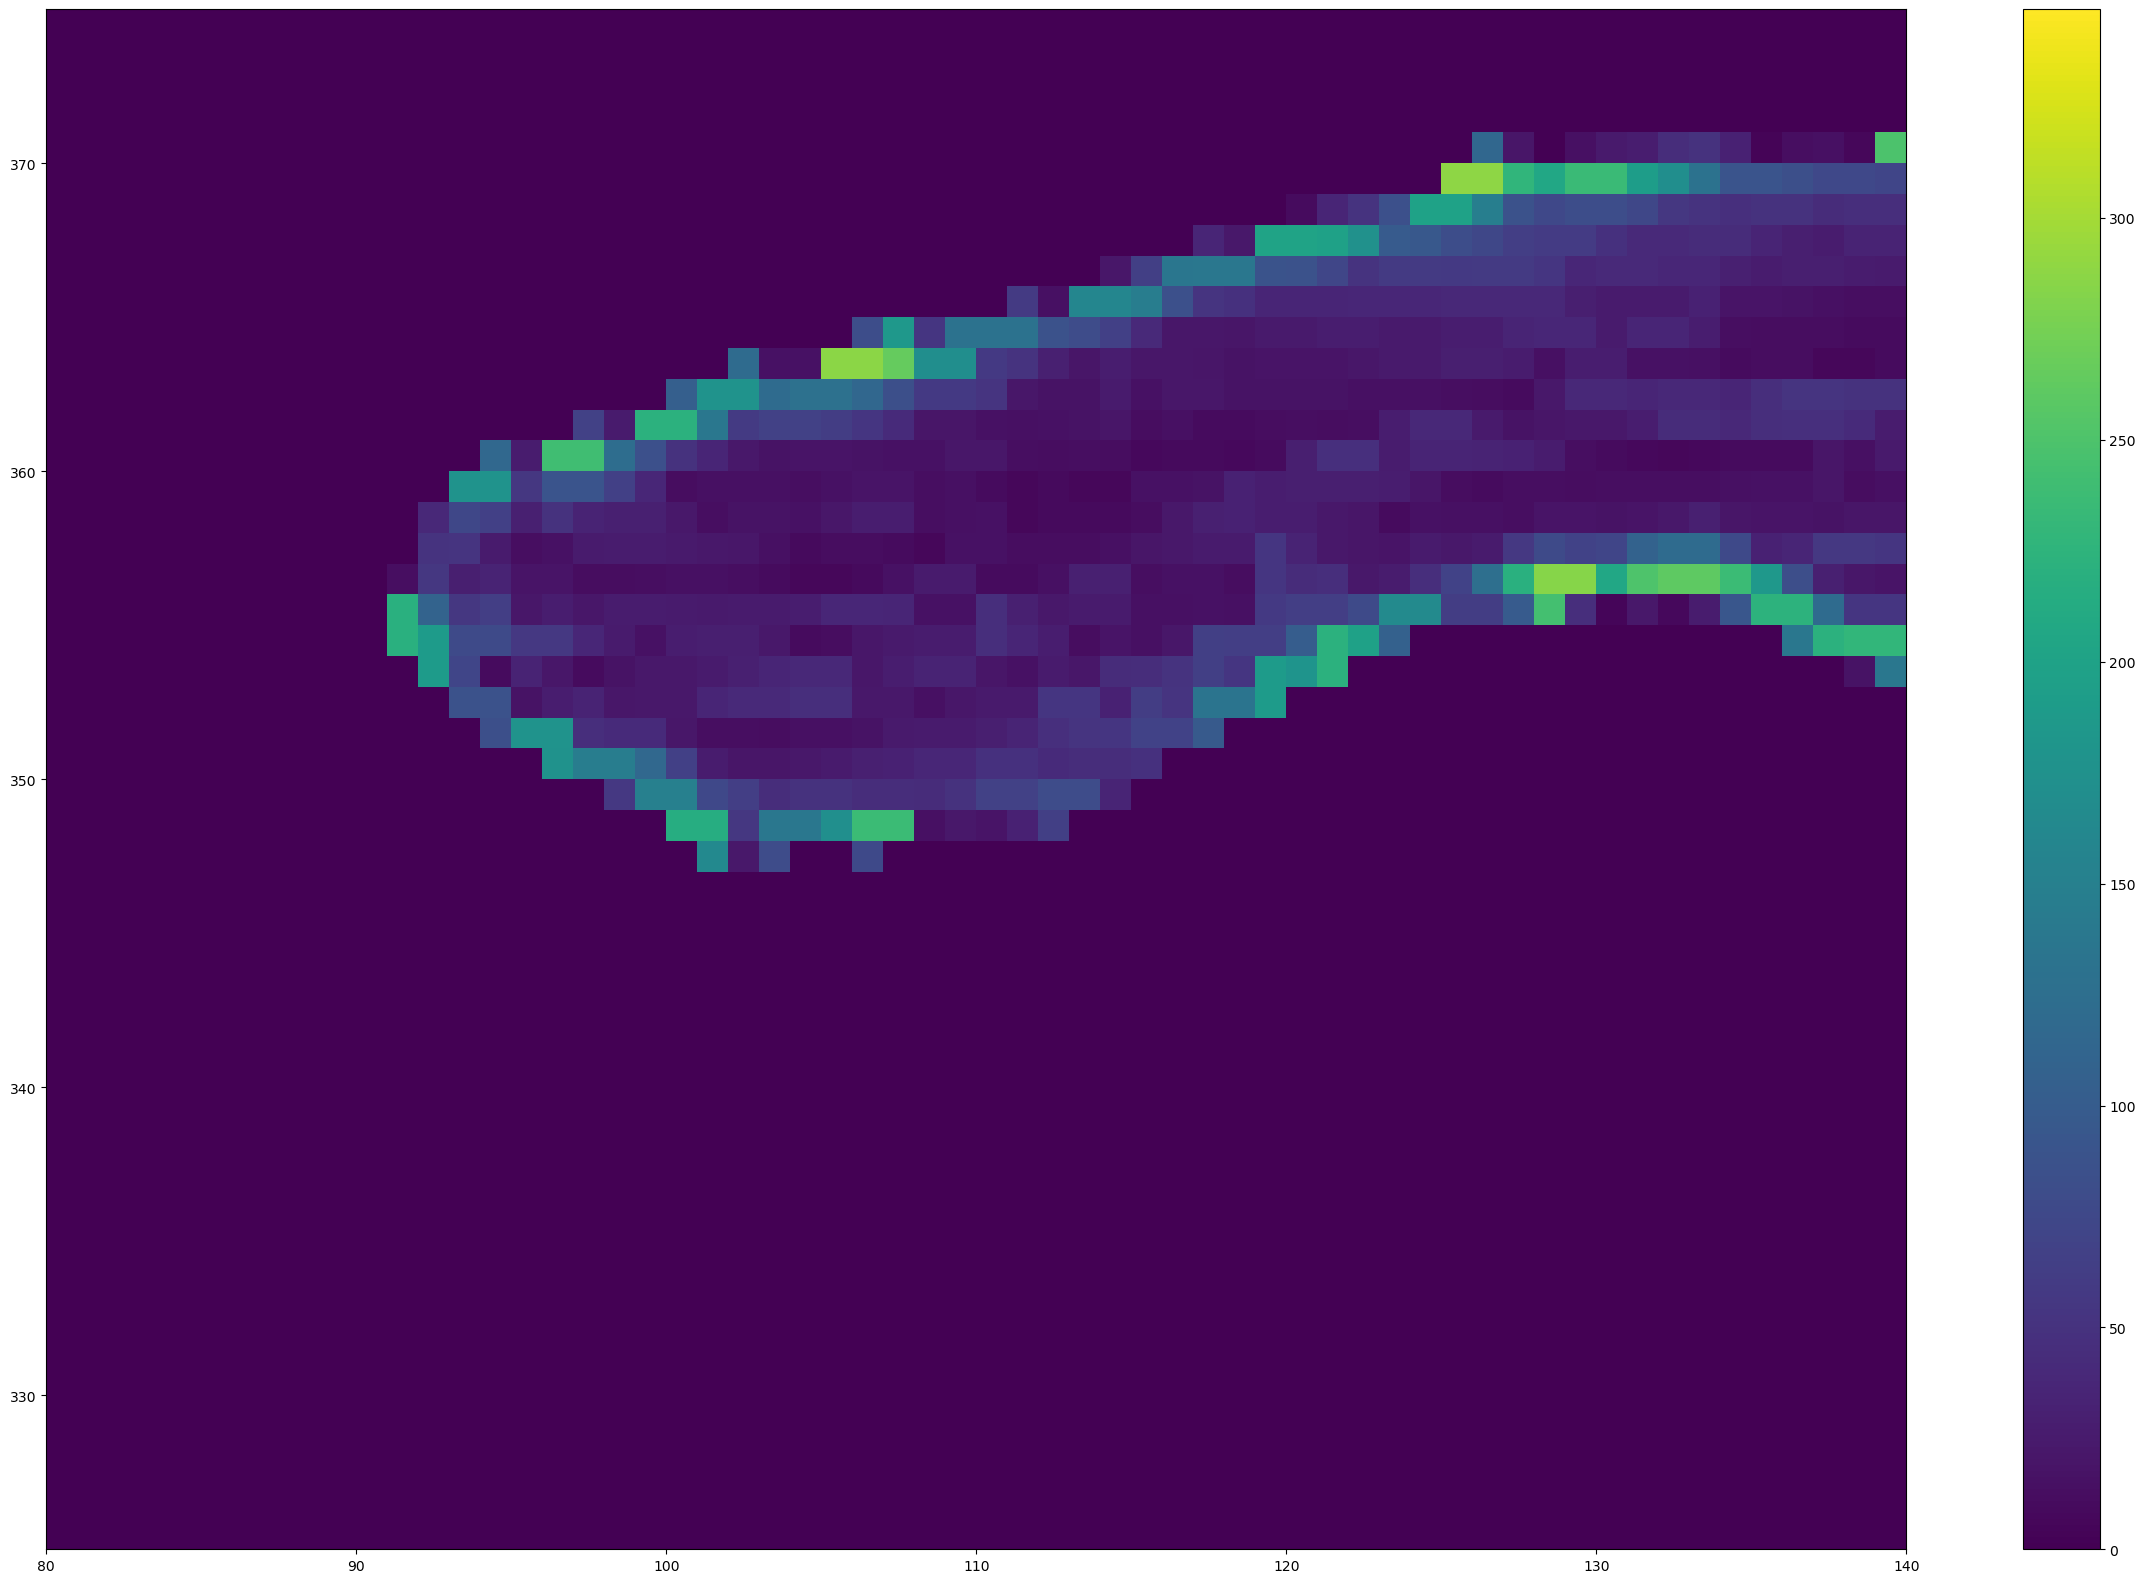

In [103]:
fig = plt.figure(figsize=(30,20))
plt.pcolormesh(grd_rx1_final)
plt.colorbar()
max_vals_y,max_vals_x=np.nonzero(grd_rx1_final>300)
max_vals_vals=grd_rx1_final[grd_rx1_final>300]
plt.plot(max_vals_x,max_vals_y,'ro')
plt.xlim(80,140)
plt.ylim(325,375)
print(max_vals_vals)


In [104]:
# if happy with above, update hhh
hhh = hhh_final.copy()
zzz = zzz_final.copy()

In [105]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=True
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh.copy()
    roms_tmp['ice']=zzz.copy()
    roms_tmp['mask']=mmm.copy()
    
    bed = hhh.copy()
    ice = zzz.copy()
    mask = mmm.copy()


updating bathy, zice and mask


In [106]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin((bed+ice)*maskNaN),'/',np.nanmax((bed+ice)*maskNaN))

whole domain
min/max zice is -3749.7085 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.1 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


In [107]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  8.67147445678711
max slow DT in s following CFL:  236.15961967599594
Set ROMS timestep settings of at least: 
 DT < 236.15961967599594 s 
 NDTFAST > 27.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.37158638959344
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8371586389593441


In [108]:
# switch coordinates so that the grid is oriented as:
# increasing xi direction towards ~east
# increasing eta direction towards ~north


In [109]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [110]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd.nc
